# Notebook 1.1 for System Biology of Aging 
This notebook is part of the first session of the 2024 Systems Biology of Aging Workshop. But don't worry about setup, all of the files and R packages should be installed in the the Sagemaker environment.

This Notebook will use the "custom-R" kernel. Double check that this is correct by looking in the top right corner.

> Outline
> * Data exploration and cleaning
> ** Dispersion of frailty measures
> ** Create baseline proteins, metabolites and clinical
> ** Dimensionality reduction
> ** Scale and impute for PCA
> * Single-Omic WGNCA
> ** Correlate with frailty
> ** Enrichment of select modules
> * Single-Omics DE
> ** DE of Proteins and Metabolites quintiles
> ** Volcano plots
> ** Enrichment

## Setup
The next couple blocks of code will load the R packages into our environment and set some options for nicer visualizaions.

In [748]:
# Load packages, one per line for clarity
suppressMessages(library("tidyverse", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("ggplot2", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("WGCNA", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("org.Hs.eg.db", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("clusterProfiler", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("limma", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("DT", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("ggpubr", quietly = TRUE, warn.conflicts=FALSE))
# Other options
source("Scripts/Workshop_scripts.R") # Functions for plotting
options(stringsAsFactors=FALSE)#Required for WGCNA
enableWGCNAThreads(nThreads=2) # 
options(repr.plot.width=7, repr.plot.height=10)#Default=7x7
options(repr.matrix.max.rows=75, repr.matrix.max.cols=20)
options(warn=-1)

Allowing parallel execution with up to 2 working processes.


# Let's Get Started! -Frailty measures

Now that our environment is ready, let's start digging into our data. In your Sagemaker environment, you should see a folders with tsv files for each of the omics and outcomes. We'll go over all of these during the anlaysis, but let's start by looking at our outcome- the frailty indices.

In [539]:
fr_measures = read_delim("../data/frailty/combination_fi_040124.csv")
dim(fr_measures)
head(fr_measures)
colnames(fr_measures)

New names:
• `` -> `...1`


[1] 3090   83

...1,public_client_id,self_fi,self_fi_sum,num_na_self,days_in_program,sex,age,race,Dise1,⋯,BP1,BP2,BP3,BP4,BP5,num_na_lab,lab_fi,lab_fi_sum,num_na_both,merge_fi
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,01001548,0.18857143,6.6,0,4,M,49,white,0,⋯,1,1,NA,1,0,1,0.36363636,12,1,0.27352941
2,01002192,0.11428571,4.0,0,0,M,26,white,0,⋯,1,1,NA,1,0,1,0.27272727,9,1,0.19117647
3,01003555,0.15757576,5.2,2,0,M,47,white,0,⋯,1,1,NA,1,0,1,0.33333333,11,3,0.24545454
4,01003662,0.16285714,5.7,0,1,M,26,white,0,⋯,0,1,NA,0,0,1,0.27272727,9,1,0.21617647
5,01006695,0.16000000,5.6,0,0,M,61,white,0,⋯,0,0,NA,0,0,1,0.03030303,1,1,0.09705882
6,01007032,0.07428571,2.6,0,0,M,48,ashkenazi jewish,0,⋯,0,1,NA,0,0,1,0.18181818,6,1,0.12647059


[1] "...1"             "public_client_id" "self_fi"          "self_fi_sum"     
 [5] "num_na_self"      "days_in_program"  "sex"              "age"             
 [9] "race"             "Dise1"            "Dise2"            "Dise3"           
[13] "Dise4"            "Dise5"            "Dise6"            "Dise7"           
[17] "Dise8"            "Dise9"            "Dise10"           "Dise11"          
[21] "Dise12"           "Dise13"           "Dise14"           "Dise15"          
[25] "SAT_1"            "SAT_2"            "SAT_3"            "SAT_4"           
[29] "SAT_5"            "SAT_6"            "ACT_1"            "ACT_2"           
[33] "ACT_3"            "ACT_4"            "ACT_5"            "ACT_6"           
[37] "ACT_7"            "ACT_8"            "ACT_9"            "Med_1"           
[41] "Med_2"            "Med_3"            "Diges1"           "Diges2"          
[45] "CHEM1"            "CHEM2"            "CHEM3"            "CHEM4"           
[49] "CHEM5"            "CHEM6"            "CHEM7"            "CHEM8"           
[53] "CHEM9"            "CHEM10"           "CHEM11"           "CHEM12"          
[57] "CHEM13"           "CHEM14"           "CHEM15"           "CHEM16"          
[61] "CHEM17"           "CHEM18"           "CHEM19"           "CHEM20"          
[65] "CHEM21"           "CHEM22"           "CHEM23"           "CHEM24"          
[69] "CHEM25"           "CHEM26"           "CHEM27"           "CHEM28"          
[73] "CHEM29"           "BP1"              "BP2"              "BP3"             
[77] "BP4"              "BP5"              "num_na_lab"       "lab_fi"          
[81] "lab_fi_sum"       "num_na_both"      "merge_fi"

In [540]:
fr_measures_key = read_delim("FI_Features.txt", show_col_types = FALSE, delim="\t")
fr_measures_key

Code,Feature
<chr>,<chr>
Dise1,autoimmune
Dise2,bladder_kidney
Dise3,cancer
Dise4,cardiometabolic
Dise5,cardiovascular
Dise6,eye_ear_nose_throat
Dise7,fatigue
Dise8,gut_gi
Dise9,lungs


When were the particpants assessed?

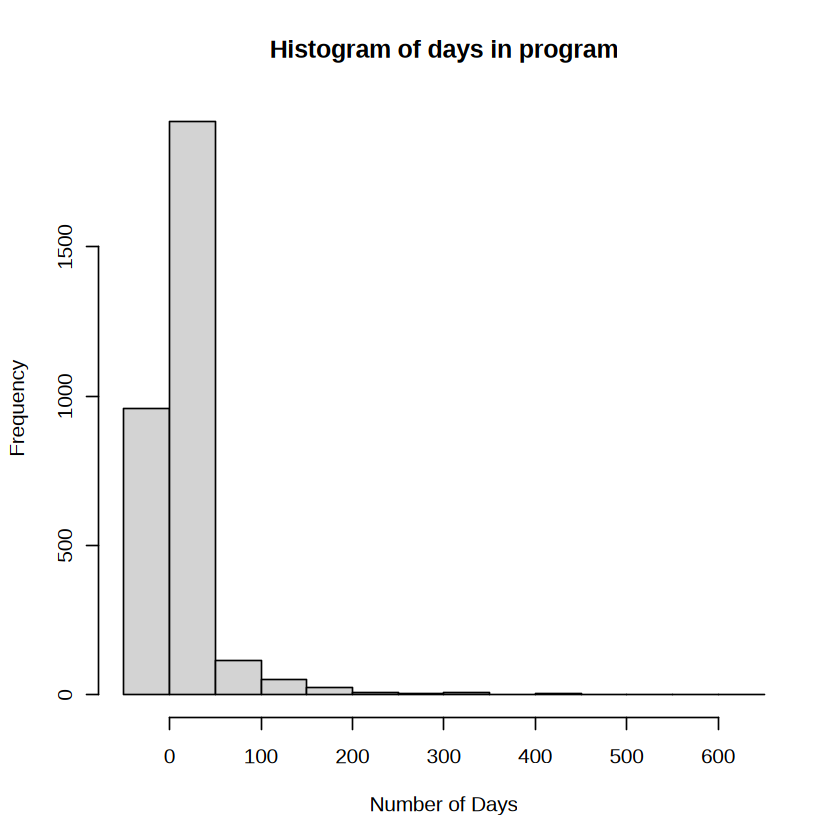

In [542]:
hist(fr_measures$days_in_program, main = "Histogram of days in program",xlab = 'Number of Days')

Next, let's look at the distribution for each of the frailty measures: lab, self assessment and the merged.

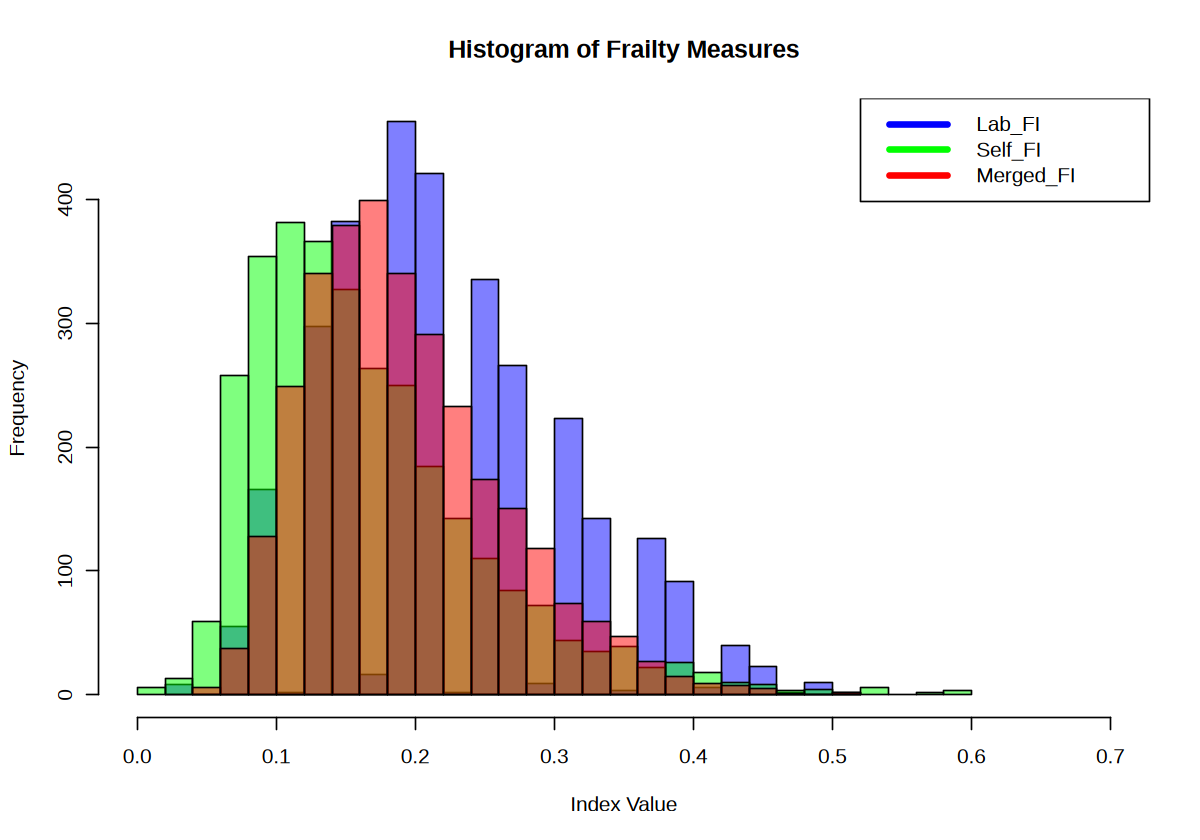

In [543]:
options(repr.plot.width=10, repr.plot.height=7)#Default=7x7
hist(fr_measures$lab_fi,  xlim=c(0,.7), col=rgb(0,0,1,2/4), breaks=25, main = "Histogram of Frailty Measures",xlab = 'Index Value') # Blue
hist(fr_measures$self_fi, add=T, xlim=c(0,.7), col=rgb(0,1,0,2/4), breaks=25) # Green
hist(fr_measures$merge_fi, add=T, xlim=c(0,.7), col=rgb(1,0,0,2/4), breaks=25) # Red

legend("topright",  c("Lab_FI", "Self_FI", "Merged_FI"), lwd=4, col=c("blue","green", "red"))

Sanity check- Frailty, in general, should increase with age. Is this what we see?

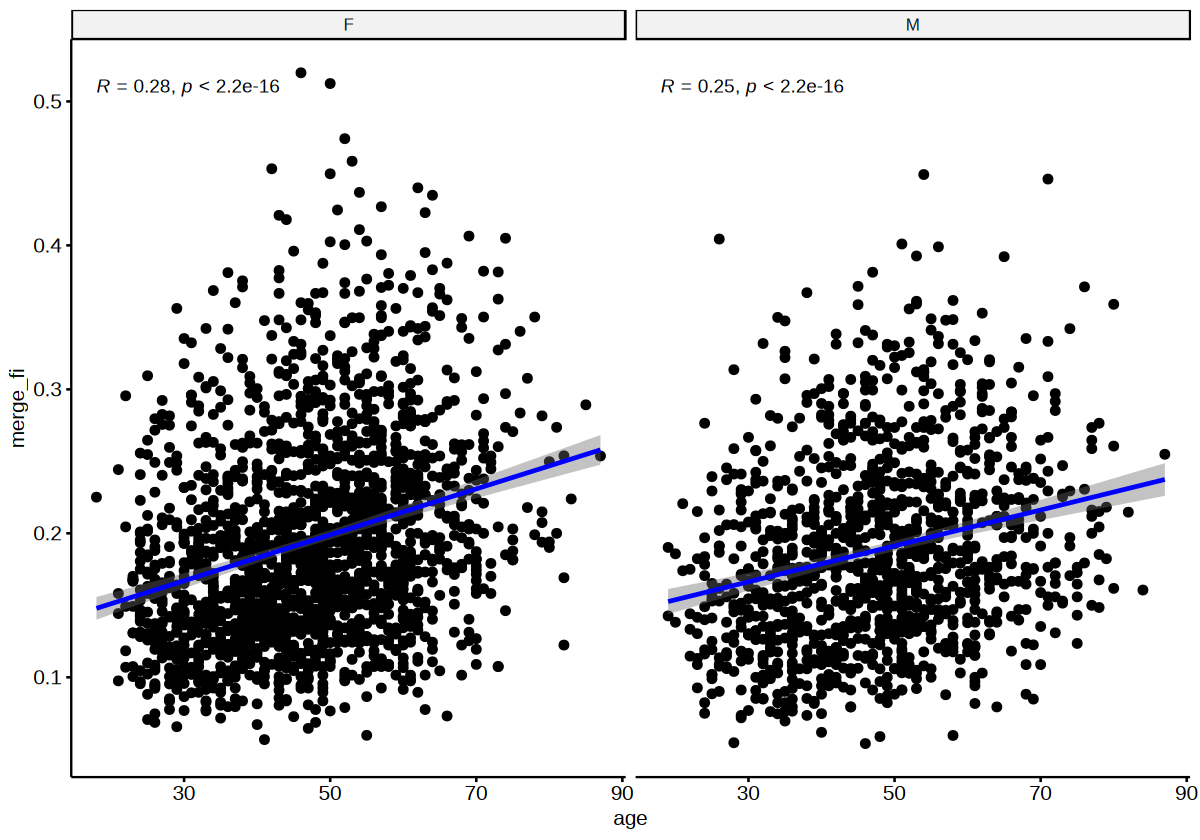

In [544]:
p1 <- ggscatter(fr_measures, x = "age", y = "merge_fi",
          add = "reg.line",                                 
          conf.int = TRUE,                                
          add.params = list(color = "blue",
                            fill = "dimgrey")
          )+
  stat_cor(method = "pearson")
facet(p1, facet.by = "sex")

# Data Cleaning

In [549]:
# Load the data
# Proteins
meta_protein = read_delim("../data/arivale_snapshot_ISB_2019-05-10_0053/proteomics_metadata.tsv", skip=13, delim='\t', show_col_types = FALSE)
proteins = read_delim("../data/arivale_snapshot_ISB_2019-05-10_0053/proteomics_corrected.tsv", skip=13, delim='\t', show_col_types = FALSE)


# Metabolites
meta_metabolites = read_delim("../data/arivale_snapshot_ISB_2019-05-10_0053/metabolomics_metadata.tsv", skip=13, delim='\t', show_col_types = FALSE)
metabolites = read_delim("../data/arivale_snapshot_ISB_2019-05-10_0053/metabolomics_corrected.tsv", skip=13, delim='\t', show_col_types = FALSE)


# Clinical labs
labs = read_delim("../data/arivale_snapshot_ISB_2019-05-10_0053/chemistries.tsv", skip=13, delim='\t', show_col_types = FALSE)

#Add Biochemical name to metabolite dataframe
new_names <- sapply(colnames(metabolites), function(x) {
  if (x %in% meta_metabolites$CHEMICAL_ID) {newrow <- meta_metabolites[meta_metabolites$CHEMICAL_ID %in% x,] 
                                            paste0(x, "(", newrow[,'BIOCHEMICAL_NAME'], ")")
  } else {x}
})
colnames(metabolites) <- new_names
#Add gene name to protein dataframe
new_names <- sapply(colnames(proteins), function(x) {
  if (x %in% meta_protein$name) {newrow <- meta_protein[meta_protein$name %in% x,] 
                                 paste0(x, "(", newrow[,'gene_name'], ")")
  } else {x}
})
colnames(proteins) <- new_names

## Metabolomics
Lets look at the data!

In [552]:
#Load the data
print("Metabolite metadata")
head(meta_metabolites)
print("Metabolites")
head(metabolites)
tail(meta_metabolites)

[1] "Metabolite metadata"


CHEMICAL_ID,SUB_PATHWAY,SUPER_PATHWAY,BIOCHEMICAL_NAME,CAS,KEGG,HMDB,PUBCHEM,MEAN_WITHIN_BATCH_CV,MEDIAN_WITHIN_BATCH_CV,ACROSS_BATCH_CV,NUM_CONTROLS_DETECTED,PERCENT_CONTROLS_DETECTED,TOTAL_CONTROLS,NUM_SAMPLES_DETECTED,PERCENT_SAMPLES_DETECTED,TOTAL_SAMPLES
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
35,Glutamate Metabolism,Amino Acid,S-1-pyrroline-5-carboxylate,2906-39-0,C04322,HMDB01301,1196,0.16220230,0.13934147,0.1926359,326,0.8670213,376,3320,0.9011944,3684
50,Polyamine Metabolism,Amino Acid,spermidine,124-20-9,C00315,HMDB01257,1102,0.24137319,0.18207422,0.3032631,327,0.8696809,376,3260,0.8849077,3684
55,Nicotinate and Nicotinamide Metabolism,Cofactors and Vitamins,1-methylnicotinamide,1005-24-9,C02918,HMDB00699,457,0.05088571,0.05013201,0.1159510,353,0.9388298,376,3478,0.9440825,3684
62,"Fatty Acid, Dihydroxy",Lipid,"12,13-DiHOME",263399-35-5,C14829,HMDB04705,10236635,0.21650512,0.18795428,0.2638650,339,0.9015957,376,3145,0.8536916,3684
71,Tryptophan Metabolism,Amino Acid,5-hydroxyindoleacetate,54-16-0,C05635,HMDB00763,1826,0.18691303,0.18084506,0.2482783,127,0.3377660,376,1512,0.4104235,3684
93,TCA Cycle,Energy,alpha-ketoglutarate,305-72-6;328-50-7;22202-68-2,C00026,HMDB00208,51,0.11480845,0.08352945,0.2005657,349,0.9281915,376,3504,0.9511401,3684


[1] "Metabolites"


public_client_id,sample_id,days_in_program,days_since_first_call,days_since_first_draw,month,weekday,season,35(S-1-pyrroline-5-carboxylate),50(spermidine),⋯,999953114(X - 24686),999953157(X - 24728),999953172(X - 24736),999953266(X - 24747),999953267(X - 24748),999954831(X - 24803),999954832(X - 24804),999954834(X - 24806),999954839(X - 24811),999954840(X - 24812)
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
01000261,A477AV558-002,65,-9,0,Jan,Tue,winter,0.9722221,2.5688976,⋯,1.0451515,0.5921748,0.4373467,0.6150178,0.9234049,1.1065246,1.1293211,1.1365539,0.3767863,NA
01001621,A391BM948-002,265,223,254,Apr,Wed,spring,1.8193021,0.7040975,⋯,NA,0.7376484,1.1092093,0.3913661,0.8446087,NA,NA,NA,NA,NA
01001621,A776BI445-003,11,-31,0,Jul,Mon,summer,2.5403780,0.5682363,⋯,2.1987038,1.0366094,2.8619600,0.9800132,1.2459661,NA,NA,NA,NA,NA
01002183,A595AV320-002,13,-1,0,Jan,Wed,winter,0.5288041,2.2607295,⋯,0.7721458,3.1092914,1.6894408,0.9235939,0.8960287,0.9159573,0.8598838,0.8627062,0.3644502,0.9324695
01002412,A294AU415-002,13,-6,0,Nov,Thu,fall,0.8631524,0.5353168,⋯,0.7252146,1.7022579,1.1553911,1.1510215,NA,0.9134076,0.8862591,NA,0.2142912,0.6393869
01002471,A945BJ353-009,194,168,153,Oct,Tue,fall,2.2329326,2.7808248,⋯,1.2253432,1.0657910,NA,NA,0.6870790,NA,NA,NA,NA,0.8164034


CHEMICAL_ID,SUB_PATHWAY,SUPER_PATHWAY,BIOCHEMICAL_NAME,CAS,KEGG,HMDB,PUBCHEM,MEAN_WITHIN_BATCH_CV,MEDIAN_WITHIN_BATCH_CV,ACROSS_BATCH_CV,NUM_CONTROLS_DETECTED,PERCENT_CONTROLS_DETECTED,TOTAL_CONTROLS,NUM_SAMPLES_DETECTED,PERCENT_SAMPLES_DETECTED,TOTAL_SAMPLES
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
999954832,NA,NA,X - 24804,NA,NA,NA,NA,0.03848047,0.03535528,0.0794717,30,0.07978723,376,981,0.2662866,3684
999954834,NA,NA,X - 24806,NA,NA,NA,NA,0.08258662,0.03767936,0.1231948,31,0.08244681,376,974,0.2643865,3684
999954839,NA,NA,X - 24811,NA,NA,NA,NA,0.14930633,0.14222407,0.2756181,201,0.53457447,376,1534,0.4163952,3684
999954840,NA,NA,X - 24812,NA,NA,NA,NA,0.15537343,0.13476987,0.1767202,323,0.85904255,376,2732,0.7415852,3684
100002397,NA,NA,alpha-ketoglutaramate*,18465-19-5,NA,NA,48,0.10969206,0.09293088,0.1626516,56,0.14893617,376,406,0.1102063,3684
100020578,NA,NA,4-allylcatechol sulfate,NA,NA,NA,NA,0.05278329,0.05036630,0.1963823,359,0.95478723,376,3337,0.9058089,3684


### Drop metabolites without annotations

In [553]:
print("Metabolites")
print(str_c("- columns: ", ncol(metabolites)))
metabolites <- metabolites[,!grepl("X -", colnames(metabolites))]
print("Metabolites after filtering")
print(str_c("- columns: ", ncol(metabolites)))

[1] "Metabolites"
[1] "- columns: 1304"
[1] "Metabolites after filtering"
[1] "- columns: 1058"


### Get baseline metabolites

Considering these participants underwent wellness coaching, we will only look at the baseline analysis for looking at associations with frailty indices. 

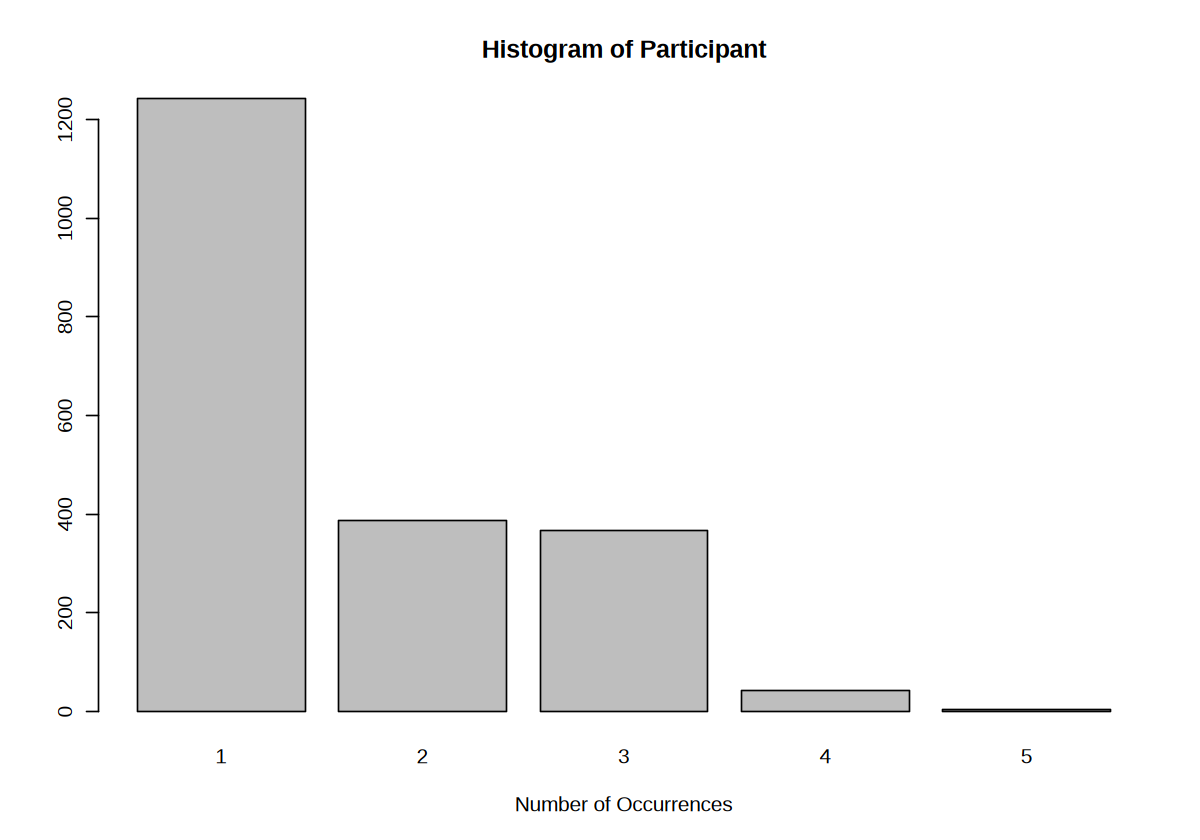

In [554]:
barplot(table(table(metabolites$public_client_id)), main = "Histogram of Participant",xlab = 'Number of Occurrences')

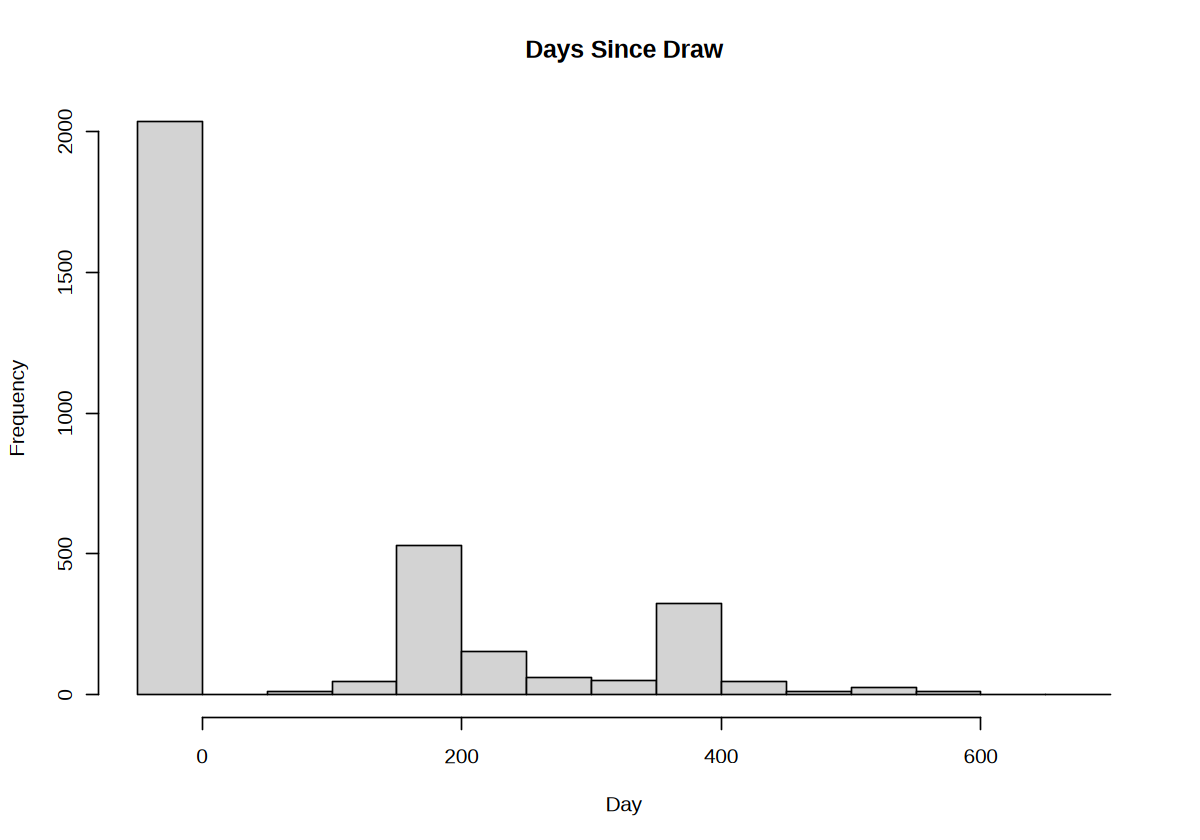

In [555]:
hist(metabolites$days_since_first_draw, main = "Days Since Draw",xlab = 'Day')

In [556]:
print("Participants metabolite records")
print(str_c("- columns: ", nrow(metabolites)))
metabolites <-metabolites %>% 
    group_by(public_client_id) %>%
    arrange(days_since_first_draw) %>%
    filter(row_number()==1) %>%
    filter(days_since_first_draw < 75)

print("Participants metabolite records after filtering")
print(str_c("- columns: ", nrow(metabolites)))

[1] "Participants metabolite records"
[1] "- columns: 3305"
[1] "Participants metabolite records after filtering"
[1] "- columns: 2033"


### Evaluate Missingness

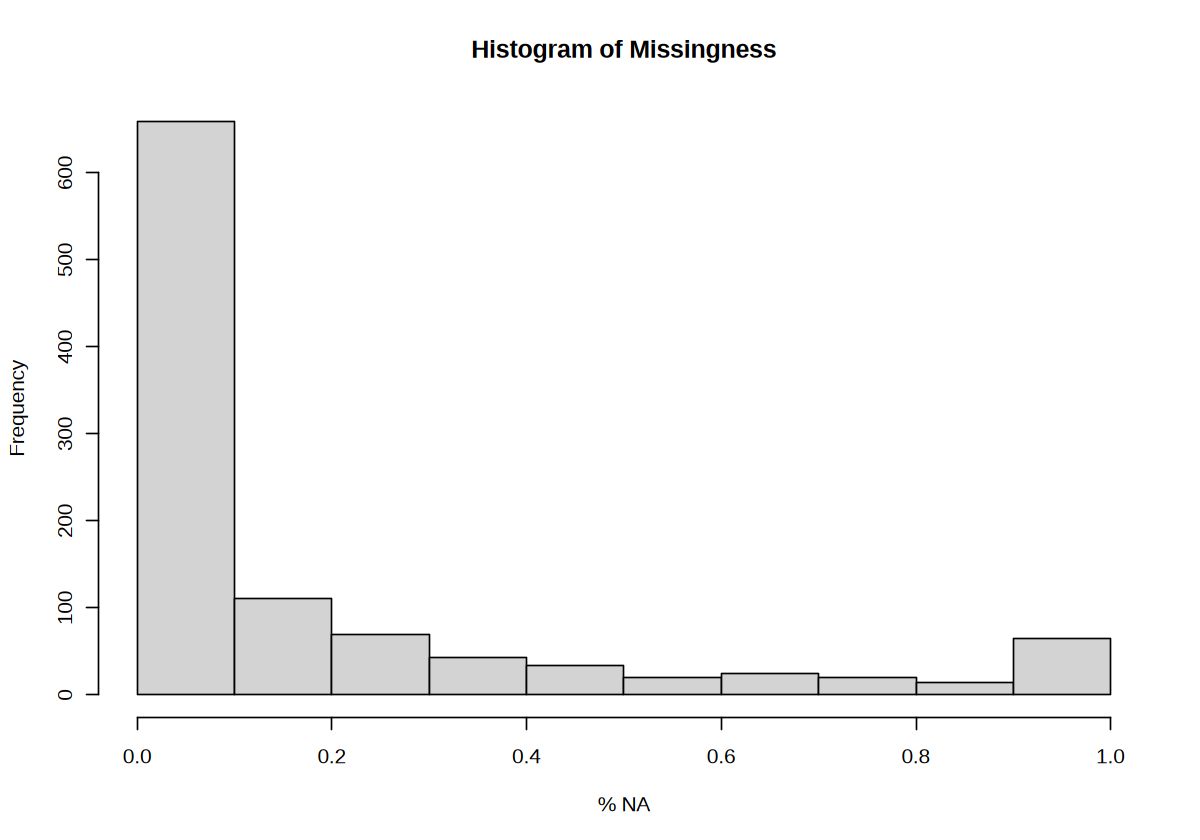

In [557]:
mets_missing <- colSums(is.na(metabolites))/nrow(metabolites)
hist(mets_missing, main = "Histogram of Missingness",xlab = '% NA')

In [558]:
mets_missing[order(mets_missing, decreasing = TRUE)[1:10]]

100001538(lidocaine) 
                                    1.0000000 
                  100002719(cotinine N-oxide) 
                                    1.0000000 
                        100003442(paroxetine) 
                                    1.0000000 
100002394(1-hydroxy-2-naphthalenecarboxylate) 
                                    0.9995081 
                          100006381(tramadol) 
                                    0.9995081 
                 100009253(mycophenolic acid) 
                                    0.9995081 
        100004177(hydroxypioglitazone (M-IV)) 
                                    0.9990162 
                      100001317(pioglitazone) 
                                    0.9985243 
                        100008943(pregabalin) 
                                    0.9985243 
                         100004015(diltiazem) 
                                    0.9980325

### Impute and Scale

When dealing with metabolites, its important to consider the method of imputation! For example, imputing with the mean or median may result in incorrect values for xenobiotics. More sophisticated imputation methods, such as random forest can be costly. 

In [559]:
metabolites_filter <- metabolites[,c(9:ncol(metabolites))] # Drop non metabolite values
metabolites_filter <- metabolites_filter[, colMeans(is.na(metabolites_filter)) <= .5]
metabolites_filter_impute <- as_tibble(impute::impute.knn(as.matrix(metabolites_filter))$data)
head(metabolites_filter_impute)

Cluster size 2028 broken into 55 1973 
Done cluster 55 
Cluster size 1973 broken into 1899 74 
Cluster size 1899 broken into 156 1743 
Done cluster 156 
Cluster size 1743 broken into 1688 55 
Cluster size 1688 broken into 1373 315 
Done cluster 1373 
Done cluster 315 
Done cluster 1688 
Done cluster 55 
Done cluster 1743 
Done cluster 1899 
Done cluster 74 
Done cluster 1973 


35(S-1-pyrroline-5-carboxylate),50(spermidine),55(1-methylnicotinamide),"62(12,13-DiHOME)",71(5-hydroxyindoleacetate),93(alpha-ketoglutarate),98(kynurenate),111(3-hydroxyisobutyrate),112(3-hydroxy-3-methylglutarate),117(homovanillate (HVA)),⋯,"100022004(bilirubin degradation product, C16H18N2O5 (2)**)","100022005(bilirubin degradation product, C17H18N2O4 (1)**)","100022006(bilirubin degradation product, C17H18N2O4 (2)**)","100022007(bilirubin degradation product, C17H18N2O4 (3)**)","100022008(bilirubin degradation product, C17H20N2O5 (1)**)","100022009(bilirubin degradation product, C17H20N2O5 (2)**)",100022013(tetrahydrocortisol glucuronide),"100022041(N,N-dimethyl-pro-pro)",100022120(oxindolylalanine),100022127(tetrahydrocortisone glucuronide (5))
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.8120445,0.9717836,1.4747071,0.3945273,1.2629148,2.7345234,1.3664110,1.2565792,1.2118343,1.467920,⋯,1.7741423,1.2738873,1.3448638,1.3579382,2.0115281,2.0524588,1.1295823,0.9427496,0.6110228,0.8964159
0.9722221,2.5688976,1.1557715,0.8244348,1.6660605,0.9475890,0.7729551,0.7168306,1.1931153,1.265563,⋯,1.0878299,1.2611141,1.0077579,0.9236489,1.2349962,1.2123621,1.7550796,1.2159123,0.8757674,1.5780188
2.5403780,0.5682363,1.3280497,0.7049045,1.0030309,1.3669079,0.9675743,1.9571495,0.9285327,1.164143,⋯,0.2333235,0.2679000,0.3057815,0.2835381,0.1699744,0.1867472,0.8384159,0.9834853,1.1259881,0.4805284
0.5288041,2.2607295,0.4250734,2.2997951,1.9403741,0.8505769,1.7378101,1.4784967,2.3359559,2.452279,⋯,1.9288947,1.7604692,1.4839163,1.4906687,2.1887822,2.2421221,1.0052202,1.4960280,0.4003367,0.9035022
0.8631524,0.5353168,1.0084296,1.3006848,1.2235681,0.8771391,0.7723711,1.0520635,1.1289915,1.649449,⋯,1.1126312,1.0528709,1.0452474,1.0194556,0.7990516,0.8499786,1.1582496,0.9424226,0.5686666,0.7830649
2.0649952,1.1113569,1.3083215,0.7738525,0.7559647,0.7600328,1.1209268,0.8643912,0.3036506,1.173906,⋯,0.7752223,0.5537469,0.6009769,0.7277116,0.9066635,0.9152842,1.3953714,0.9953826,1.1683813,1.2185600


### PCA

In [560]:
PCA_mets_all <- prcomp(metabolites_filter_impute, center=TRUE, scale=TRUE)
PCA_mets <- cbind(metabolites[,c(1:8)], PCA_mets_all$x[,c(1:4)])
PCA_mets <- merge(PCA_mets, fr_measures, by="public_client_id")

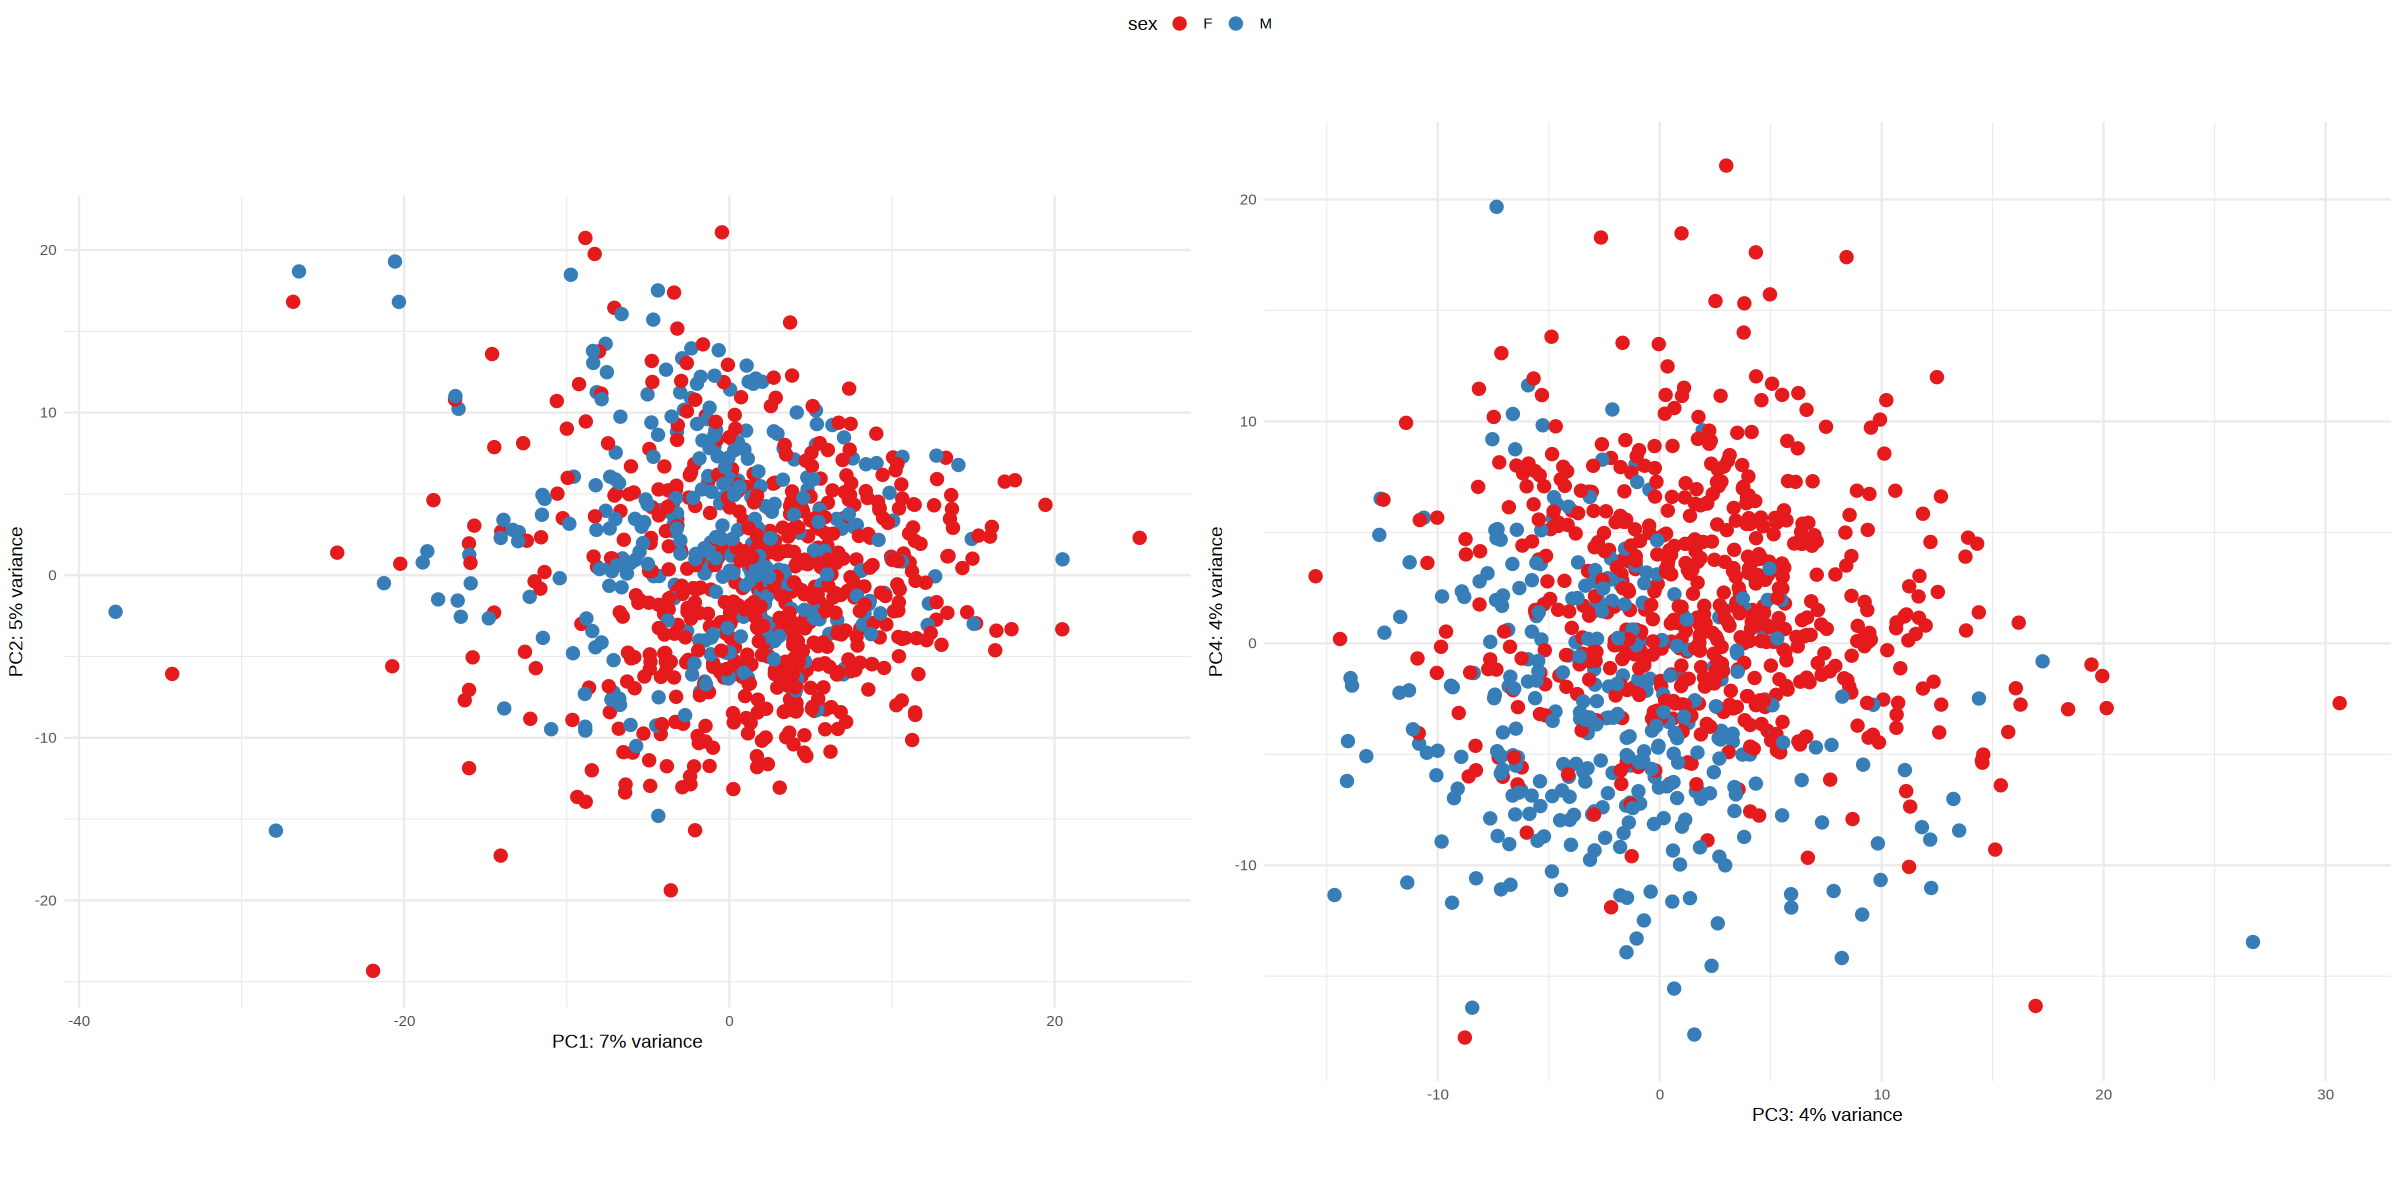

In [571]:
percentVar <- PCA_mets_all$sdev^2 / sum(PCA_mets_all$sdev^2 )

p1 <- ggplot(PCA_mets, aes(x=PC1, y=PC2, color=sex)) +
    geom_point(size=3) + scale_color_brewer(palette="Set1") +
    xlab(paste0("PC1: ",round(percentVar[1] * 100),"% variance")) +
    ylab(paste0("PC2: ",round(percentVar[2] * 100),"% variance")) +
     theme_minimal() +
    coord_fixed()
p2 <- ggplot(PCA_mets, aes(x=PC3, y=PC4, color=sex)) +
    geom_point(size=3) + scale_color_brewer(palette="Set1") +
    xlab(paste0("PC3: ",round(percentVar[3] * 100),"% variance")) +
    ylab(paste0("PC4: ",round(percentVar[4] * 100),"% variance")) +
     theme_minimal() +
    coord_fixed()
options(repr.plot.width=20, repr.plot.height=10)#Default=7x7
ggarrange(p1, p2,  common.legend = TRUE)


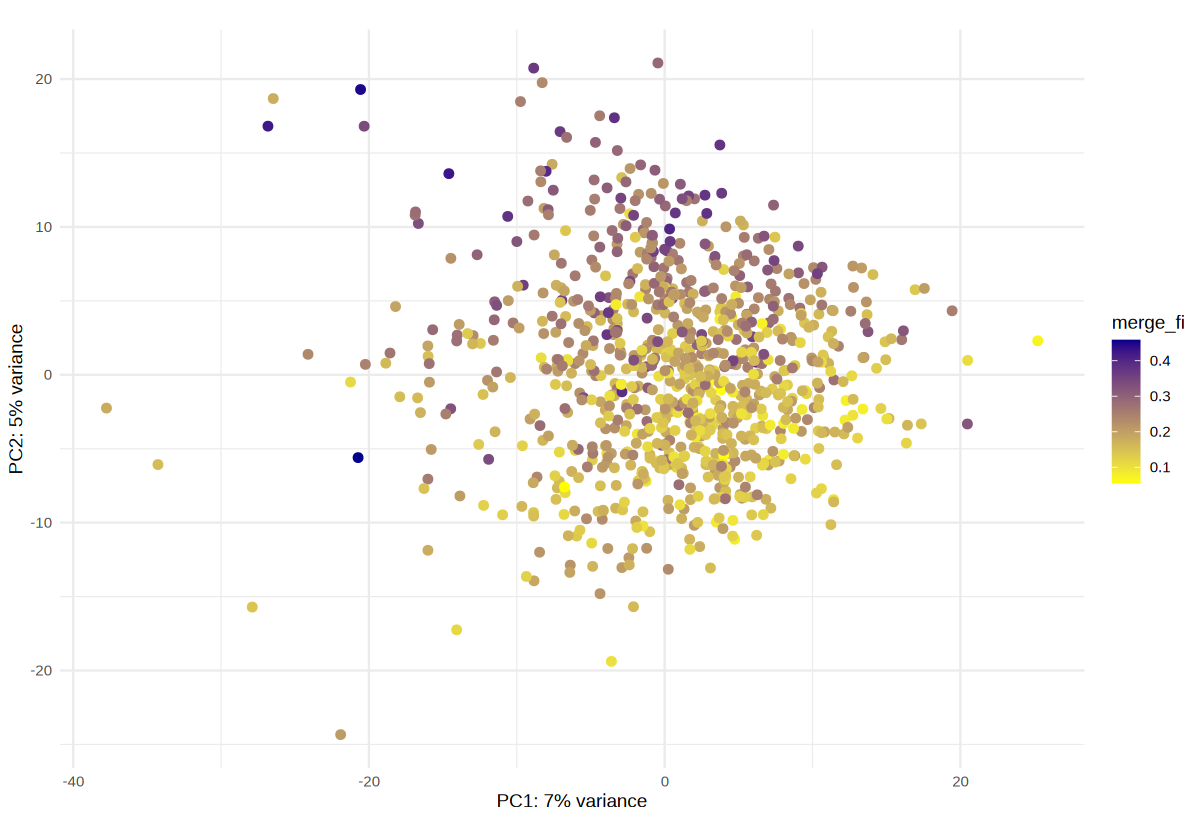

In [572]:
options(repr.plot.width=10, repr.plot.height=7)#Default=7x7
ggplot(PCA_mets, aes(x=PC1, y=PC2, color=merge_fi)) +
    geom_point(size=2) + scale_color_gradient(low = "yellow", high = "darkblue") +
    xlab(paste0("PC1: ",round(percentVar[1] * 100),"% variance")) +
    ylab(paste0("PC2: ",round(percentVar[2] * 100),"% variance")) +
    theme_minimal() +
    coord_fixed()



 We'll leave it there for now, but will come back to PCA in session three.

## Proteins

Proteins follow the same analysis pattern as metabolites. We'll skip going over in detail. 

In [573]:
print("Participants protein records")
print(str_c("- columns: ", nrow(proteins)))
proteins <-proteins %>% 
    group_by(public_client_id) %>%
    arrange(days_since_first_draw) %>%
    filter(row_number()==1) %>%
    filter(days_since_first_draw < 75)

print("Participants protein records")
print(str_c("- columns: ", nrow(proteins)))

[1] "Participants protein records"
[1] "- columns: 6112"
[1] "Participants protein records"
[1] "- columns: 2839"


## *Exercise- Proteins PCA*
What, if anything, needs to be considered when imputing and filtering proteins?
Try 3 imputation methods, Zero, Mean and KNN. Does this change the PCA?

## Clinical Labs

In [574]:
print("Participants chemisty records")
print(str_c("- columns: ", nrow(chemistry)))
chemistry <-chemistry %>% 
    group_by(public_client_id) %>%
    arrange(days_since_first_draw) %>%
    filter(row_number()==1) %>%
    filter(days_since_first_draw < 75)

print("Participants chemistry records")
print(str_c("- columns: ", nrow(chemistry)))

[1] "Participants chemisty records"
[1] "- columns: 11167"
[1] "Participants chemistry records"
[1] "- columns: 4878"


In [575]:
colnames(chemistry)

[1] "public_client_id"               "vendor"                        
  [3] "vendor_observation_id"          "observation_id"                
  [5] "reflexive"                      "fasting"                       
  [7] "days_in_program"                "days_since_first_call"         
  [9] "days_since_first_draw"          "month"                         
 [11] "weekday"                        "season"                        
 [13] "A/G RATIO"                      "ADIPONECTIN, SERUM"            
 [15] "ALAT (SGPT)"                    "ALBUMIN"                       
 [17] "ALKALINE PHOSPHATASE"           "ANTIOXID CAP, TOTAL"           
 [19] "ARACHIDONIC ACID"               "ARSENIC, BLOOD"                
 [21] "ASAT (SGOT)"                    "BASOPHILS"                     
 [23] "BASOPHILS ABSOLUTE"             "BILIRUBIN, DIRECT"             
 [25] "BILIRUBIN, INDIRECT"            "BILIRUBIN, TOTAL"              
 [27] "BUN/CREAT RATIO"                "CALCIUM"                       
 [29] "CARBON DIOXIDE (CO2)"           "CHLORIDE"                      
 [31] "CHOLESTEROL, TOTAL"             "COPPER, RBC"                   
 [33] "CREATININE ENZ, SER"            "CRP HIGH SENSITIVITY"          
 [35] "DHA"                            "DPA"                           
 [37] "EOSINOPHILS"                    "EOSINOPHILS ABSOLUTE"          
 [39] "EPA"                            "EPA/AA"                        
 [41] "FERRITIN"                       "FOLIC ACID, SERUM"             
 [43] "GFR, MDRD"                      "GFR, MDRD, AFRICAN AM"         
 [45] "GGT"                            "GLOBULIN"                      
 [47] "GLUCOSE"                        "GLUTATHIONE, TOTAL"            
 [49] "GLYCOHEMOGLOBIN A1C"            "HDL CHOL DIRECT"               
 [51] "HDL LARGE"                      "HDL PARTICLE NUMBER"           
 [53] "HDL PARTICLE PERCENTILE"        "HDL SIZE PERCENTILE"           
 [55] "HEMATOCRIT"                     "HEMOGLOBIN"                    
 [57] "HOMA-IR"                        "HOMOCYSTEINE, SERUM"           
 [59] "IDL PARTICLE NUMBER"            "IL-6"                          
 [61] "IL-8"                           "IMMATURE GRANULOCYTES"         
 [63] "IMMATURE GRANULOCYTES ABSOLUTE" "INSULIN"                       
 [65] "LACTIC DEHYDROGENASE"           "LARGE HDL PARTICLE PERCENTILE" 
 [67] "LARGE LDL PARTICLE NUMBER"      "LARGE MED HDL PARTICLE NUMBER" 
 [69] "LARGE MED VLDL PARTICLE NUMBER" "LARGE VLDL PARTICLE PERCENTILE"
 [71] "LDL MEDIUM"                     "LDL PARTICLE NUMBER"           
 [73] "LDL PEAK SIZE"                  "LDL SIZE PERCENTILE"           
 [75] "LDL SMALL"                      "LDL-CHOL CALCULATION"          
 [77] "LDL_SIZE"                       "LEAD, BLOOD"                   
 [79] "LINOLEIC_ACID"                  "LPIR SCORE PERCENTILE"         
 [81] "LPIR_SCORE"                     "LP_PLA2"                       
 [83] "LYMPHOCYTES"                    "LYMPHOCYTES ABSOLUTE"          
 [85] "MAGNESIUM, SERUM"               "MANGANESE, SERUM"              
 [87] "MCH"                            "MCHC"                          
 [89] "MCV"                            "MEDIUM HDL PARTICLE NUMBER"    
 [91] "MEDIUM VLDL PARTICLE NUMBER"    "MERCURY, BLOOD"                
 [93] "METHYLMALONIC ACID"             "MONOCYTES"                     
 [95] "MONOCYTES ABSOLUTE"             "MPV"                           
 [97] "NEUTROPHIL, SEGS"               "NEUTROPHILS ABSOLUTE"          
 [99] "OMEGA-3 INDEX"                  "OMEGA-6/OMEGA-3 RATIO"         
[101] "OMEGA_3_TOTAL"                  "OMEGA_6_TOTAL"                 
[103] "OXLDL"                          "PAI-1 ANTIGEN, QNT"            
[105] "PFFA"                           "PHOSPHORUS INORGANIC"          
[107] "PLATELET COUNT"                 "PLATELET COUNT THOUSAND"       
[109] "POTASSIUM"                      "PROT AND PFFA CALC"            
[111] "PROTEIN"                        "PR

In [576]:
### Save these for later to re-run analysis below without having to run the code above. 
dir.create("./Session1_files/", showWarnings = FALSE)
write_delim(metabolites[,c(1,9:ncol(metabolites))], "./Session1_files/metabolites_baseline.tsv", delim="\t")
write_delim(proteins[,c(1,22:ncol(proteins))], "./Session1_files/proteins_baseline.tsv", delim="\t")
write_delim(chemistry[,c(1,13:ncol(chemistry))], "./Session1_files/chemistries_baseline.tsv", delim="\t")

# WGCNA Proteins

## Prepare data

In [583]:
dataset_label <- "Proteomics"#For label purpose; Fix throughout this notebook
omics <- proteins[,c(1,22:ncol(proteins))]

#Select the participants having both data
##Analyte data
data_df <- omics %>%
    dplyr::filter(public_client_id %in% fr_measures$public_client_id) %>%
    dplyr::arrange(public_client_id) %>%#Sort row order
    #Transform tibble for easily applying to the WGCNA functions
    column_to_rownames(var="public_client_id")
data_df <- data_df[, order(colnames(data_df))]#Sort column order
print("Data")
print(str_c("- nrow: ", nrow(data_df)))
head(data_df)
##Sample metadata
sample_tbl <- fr_measures %>%
    dplyr::filter(public_client_id %in% omics$public_client_id) %>%
    dplyr::arrange(public_client_id)#Sort row order
print("Sample metadata")
print(str_c("- nrow: ", nrow(sample_tbl)))
head(sample_tbl)

# Prepare metadata
analyte_tbl <- meta_protein %>%
    #Prepare the same analyte IDs within the data table
    dplyr::mutate(AnalyteID=str_c(name,"(",gene_name,")"), Dataset=dataset_label) %>%
    #Clean
    dplyr::rename(AnalyteID_original=name, PanelID=panel, UniProtID=uniprot, GeneSymbol=gene_name) %>%
    dplyr::select(AnalyteID, Dataset, AnalyteID_original, PanelID, UniProtID, GeneSymbol)

#Filter analytes within the data table
analyte_tbl <- analyte_tbl %>%
    dplyr::filter(AnalyteID %in% colnames(data_df)) %>%
    dplyr::arrange(AnalyteID)#Sort row order
print("Analyte metadata")
print(str_c("- nrow: ", nrow(analyte_tbl)))
head(analyte_tbl)

[1] "Data"
[1] "- nrow: 1368"


,CAM_O00533(CHL1),CAM_O14786(NRP1),CAM_O15031(PLXNB2),CAM_O75015(FCGR3B),CAM_O75023(LILRB5),CAM_O95445(APOM),CAM_P00441(SOD1),CAM_P00915(CA1),CAM_P01033(TIMP1),CAM_P01034(CST3),⋯,ONC3_Q9NTU7(CBLN4),ONC3_Q9P1Z2(CALCOCO1),ONC3_Q9UDT6(CLIP2),ONC3_Q9UHD8(SEPT9),ONC3_Q9UJY5(GGA1),ONC3_Q9UMF0(ICAM5),ONC3_Q9Y2B0(CNPY2),ONC3_Q9Y5K2(KLK4),ONC3_Q9Y5K8(ATP6V1D),ONC3_Q9Y644(RFNG)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
01001621,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
01001661,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
01002192,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
01002885,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
01003555,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
01003757,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


[1] "Sample metadata"
[1] "- nrow: 1368"


...1,public_client_id,self_fi,self_fi_sum,num_na_self,days_in_program,sex,age,race,Dise1,⋯,BP1,BP2,BP3,BP4,BP5,num_na_lab,lab_fi,lab_fi_sum,num_na_both,merge_fi
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1221,01001621,0.1000000,3.400000,0,0,F,54,white,0,⋯,0,1,NA,0,0,1,0.1515152,5,1,0.1253731
1222,01001661,0.1572917,5.033333,2,8,F,30,east asian,0,⋯,0,0,NA,0,0,1,0.1515152,5,3,0.1543590
2,01002192,0.1142857,4.000000,0,0,M,26,white,0,⋯,1,1,NA,1,0,1,0.2727273,9,1,0.1911765
1224,01002885,0.1625000,5.200000,2,0,F,42,white,0,⋯,0,0,NA,0,1,1,0.1212121,4,3,0.1415385
3,01003555,0.1575758,5.200000,2,0,M,47,white,0,⋯,1,1,NA,1,0,1,0.3333333,11,3,0.2454545
1226,01003757,0.1215686,4.133333,0,1,F,24,south asian,0,⋯,0,1,NA,0,0,1,0.3939394,13,1,0.2557214


[1] "Analyte metadata"
[1] "- nrow: 1195"


AnalyteID,Dataset,AnalyteID_original,PanelID,UniProtID,GeneSymbol
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CAM_O00533(CHL1),Proteomics,CAM_O00533,CAM,O00533,CHL1
CAM_O14786(NRP1),Proteomics,CAM_O14786,CAM,O14786,NRP1
CAM_O15031(PLXNB2),Proteomics,CAM_O15031,CAM,O15031,PLXNB2
CAM_O75015(FCGR3B),Proteomics,CAM_O75015,CAM,O75015,FCGR3B
CAM_O75023(LILRB5),Proteomics,CAM_O75023,CAM,O75023,LILRB5
CAM_O95445(APOM),Proteomics,CAM_O95445,CAM,O95445,APOM


## Missingness

WGNCA provides a function to filter for missingness. This filter both columns (features) and rows (participants).

In [584]:
#Filter samples and features based on the default WGCNA NA criteria (50%)
gsg = goodSamplesGenes(data_df, verbose = 3);
gsg$allOK
if (!gsg$allOK)
{
  # Optionally, print the gene and sample names that were removed:
  if (sum(!gsg$goodGenes)>0) 
     printFlush(paste("Removing genes:", paste(names(data_df)[!gsg$goodGenes], collapse = ", ")));
  if (sum(!gsg$goodSamples)>0) 
     printFlush(paste("Removing samples:", paste(rownames(data_df)[!gsg$goodSamples], collapse = ", ")));
  # Remove the offending genes and samples from the data:
  data_df = data_df[gsg$goodSamples, gsg$goodGenes]
}

print("After the filter:")
print(dim(data_df))

#Filter metadata to match columns in filtered data frame
sample_tbl <- sample_tbl %>%
    dplyr::filter(public_client_id %in% rownames(data_df))
print("Sample metadata after the filter")
print(str_c("- nrow: ", nrow(sample_tbl)))

analyte_tbl <- analyte_tbl %>%
    dplyr::filter(AnalyteID %in% colnames(data_df))
print("Analyte metadata after the filter")
print(str_c("- nrow: ", nrow(analyte_tbl)))

 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 921 genes from the calculation due to too many missing samples or zero variance.
  ..step 2


[1] FALSE

Removing genes: CAM_O00533(CHL1), CAM_O14786(NRP1), CAM_O15031(PLXNB2), CAM_O75015(FCGR3B), CAM_O75023(LILRB5), CAM_O95445(APOM), CAM_P00441(SOD1), CAM_P00915(CA1), CAM_P01033(TIMP1), CAM_P01034(CST3), CAM_P03950(ANG), CAM_P03951(F11), CAM_P04070(PROC), CAM_P05154(SERPINA5), CAM_P05362(ICAM1), CAM_P05451(REG1A), CAM_P05543(SERPINA7), CAM_P06681(C2), CAM_P07359(GP1BA), CAM_P07451(CA3), CAM_P07478(PRSS2), CAM_P07911(UMOD), CAM_P08581(MET), CAM_P08709(F7), CAM_P0CG05(IGLC2,IGLC3), CAM_P10721(KIT), CAM_P11215(ITGAM), CAM_P11226(MBL2), CAM_P12318(FCGR2A), CAM_P12830(CDH1), CAM_P13501(CCL5), CAM_P13591(NCAM1), CAM_P13987(CD59), CAM_P14151(SELL), CAM_P14543(NID1), CAM_P15529(CD46), CAM_P15907(ST6GAL1), CAM_P16871(IL7R), CAM_P17813(ENG), CAM_P17936(IGFBP3), CAM_P19021(PAM), CAM_P19320(VCAM1), CAM_P20023(CR2), CAM_P20062(TCN2), CAM_P22105(TNXB), CAM_P22748(CA4), CAM_P22749(GNLY), CAM_P23141(CES1), CAM_P24592(IGFBP6), CAM_P24821(TNC), CAM_P27487(DPP4), CAM_P32942(ICAM3), CAM_P35443(THBS4), CAM_P

Why are there so many protiens filtered? The majority of Arivale partipants were run with 3 Olink panels, however a small subset were run with a larger number of panels. Since we need to remove these proteins, we will update the metadata for easier handling. 

## Network construction

### Choose the soft-thresholding power

pickSoftThreshold: will use block size 274.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 274 of 274
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.6910 11.000          0.840 158.000   160.000 177.00
2      2   0.4990  4.090          0.729  93.300    94.600 118.00
3      3   0.2190  1.710          0.716  56.000    57.400  79.90
4      4   0.0920  0.810          0.805  34.300    35.100  55.30
5      5   0.0020 -0.103          0.831  21.400    21.600  39.10
6      6   0.0651 -0.497          0.832  13.600    13.500  28.20
7      7   0.1750 -0.486          0.927   8.900     8.490  20.70
8      8   0.4770 -0.762          0.925   5.950     5.420  15.70
9      9   0.7570 -1.100          0.968   4.070     3.500  13.10
10    10   0.8570 -1.280          0.982   2.860     2.300  11.10
11    11   0.8930 -1.380          0.944   2.060     1.510   9.54
12    12   0.9160 -1.470          0.941   1.520     1.010   8.31
13 

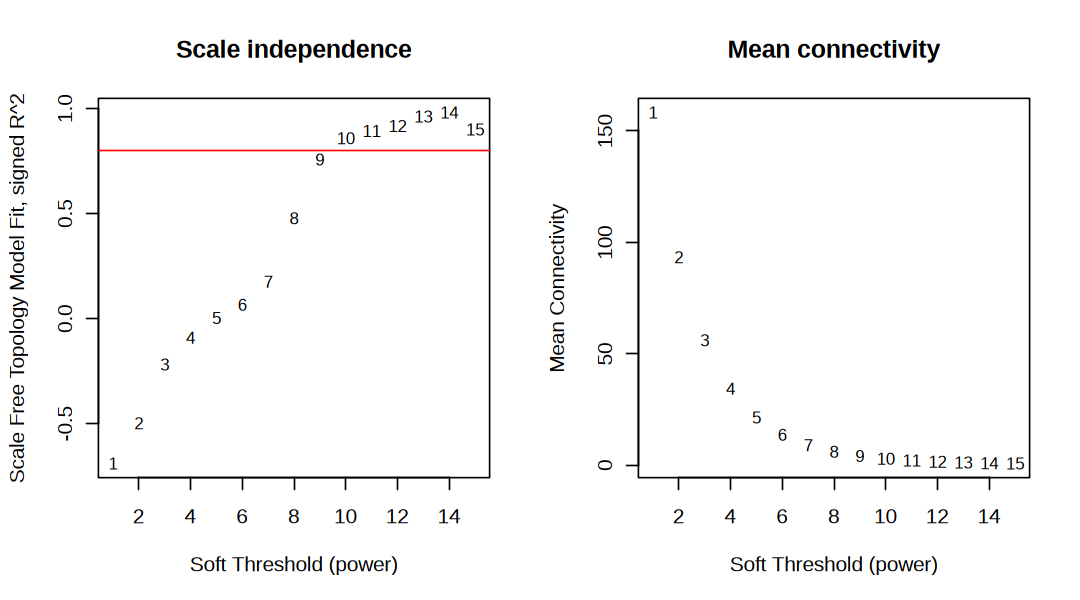

In [585]:
#Choose a set of soft-thresholding powers
powers <- c(c(1:10), seq(from=11, to=15, by=1))
cutoff <- 0.8

#Call the network topology analysis function
sft <- pickSoftThreshold(data_df, powerVector=powers, verbose=5,
                         corOptions=c(use="p", method="spearman"), networkType="signed")

#Plot the results
options(repr.plot.width=9, repr.plot.height=5)
par(mfrow=c(1,2))
cex1 <- 0.8
##Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)", ylab="Scale Free Topology Model Fit, signed R^2", type="n",
     main=paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers, cex=cex1, col="black")
##Line corresponds to using an R^2 cut-off of h
abline(h=cutoff, col="red")
##Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)", ylab="Mean Connectivity", type="n",
     main=paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1, col="black")

print(str_c("Estimated soft-thresholding power: ", sft$powerEstimate))

### Co-expression similarity and adjacency

> Calculate correlation network adjacency.  

In [605]:
#Choose the power that best approximates a scale free topology while still maintaining high level of connectivity in the network
softPower <- sft$powerEstimate

#Generate the adjacency matrix using the chosen soft-thresholding power
adjacency <- adjacency(data_df, power=softPower,
                       corOptions=list(use="p", method="spearman"), type="signed")

print(str_c("nrow: ", nrow(adjacency)))
head(adjacency)

[1] "nrow: 274"


,CVD2_O00182(LGALS9),CVD2_O00220(TNFRSF10A),CVD2_O00253(AGRP),CVD2_O14763(TNFRSF10B),CVD2_O14836(TNFRSF13B),CVD2_O43915(FIGF),CVD2_O94907(DKK1),CVD2_P00797(REN),CVD2_P01127(PDGFB),CVD2_P01241(GH1),⋯,INF_Q99748(NRTN),INF_Q9BZW8(CD244),INF_Q9GZV9(FGF23),INF_Q9H5V8(CDCP1),INF_Q9NRJ3(CCL28),INF_Q9NSA1(FGF21),INF_Q9NYY1(IL20),INF_Q9NZQ7(CD274),INF_Q9P0M4(IL17C),INF_Q9UHF4(IL20RA)
CVD2_O00182(LGALS9),1.0000000000,0.052033827,0.0008418395,0.081473749,0.023677568,0.0003826832,0.008031812,0.0045200933,0.005362203,0.0002630008,⋯,0.0023166739,0.010825685,0.016624218,0.0572241902,0.0009947030,0.0209763896,0.0027430463,0.0180904953,0.004481748,0.0038518401
CVD2_O00220(TNFRSF10A),0.0520338270,1.000000000,0.0013484630,0.060866949,0.025097852,0.0018896164,0.015885624,0.0043655797,0.010780592,0.0010847591,⋯,0.0023583168,0.007670874,0.009567482,0.0207059166,0.0026063326,0.0119553083,0.0026335175,0.0102132633,0.006951664,0.0032747662
CVD2_O00253(AGRP),0.0008418395,0.001348463,1.0000000000,0.002244546,0.006952077,0.0027183275,0.003333448,0.0021761073,0.002902153,0.0008679175,⋯,0.0019383420,0.002572511,0.001614118,0.0001683217,0.0008360673,0.0008429918,0.0026142737,0.0040934822,0.001450241,0.0005768421
CVD2_O14763(TNFRSF10B),0.0814737487,0.060866949,0.0022445457,1.000000000,0.030124880,0.0036998773,0.006777214,0.0052374230,0.003543320,0.0010842944,⋯,0.0009971327,0.005166589,0.011287663,0.0370903163,0.0022010924,0.0102934370,0.0026762028,0.0154263094,0.005841264,0.0028806021
CVD2_O14836(TNFRSF13B),0.0236775684,0.025097852,0.0069520774,0.030124880,1.000000000,0.0037962240,0.010195123,0.0039149654,0.006785030,0.0006649121,⋯,0.0037509668,0.007269747,0.005860417,0.0056029881,0.0048051289,0.0030322428,0.0031638126,0.0107171982,0.004808921,0.0039159471
CVD2_O43915(FIGF),0.0003826832,0.001889616,0.0027183275,0.003699877,0.003796224,1.0000000000,0.001900350,0.0007095432,0.001121656,0.0064962796,⋯,0.0007295591,0.001009556,0.000813405,0.0009017343,0.0047678866,0.0004301849,0.0006603639,0.0005353963,0.001053091,0.0007748400


### Topological Overlap Matrix (TOM)

> To minimize effects of noise and spurious associations, the adjacency is transformed into the topological overlap measure, and the corresponding dissimilarity is calculated.  

In [606]:
#Turn adjacency into topological overlap
##You can input whatever matrix you want here!
TOM <- TOMsimilarity(adjacency, TOMType="signed")

#Turn into distance matrix
dissTOM <- 1 - TOM

print(str_c("nrow: ", nrow(dissTOM)))
head(dissTOM)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
[1] "nrow: 274"


0.0000000,0.9635295,0.9938108,0.9550417,0.9745904,0.9960971,0.9820796,0.9882608,0.9842995,0.9977076,⋯,0.9923162,0.9850101,0.9763626,0.9617711,0.9936608,0.9712546,0.9911845,0.9795030,0.9867637,0.9900229
0.9635295,0.0000000,0.9944410,0.9636921,0.9793521,0.9951770,0.9733538,0.9910825,0.9758943,0.9971081,⋯,0.9938785,0.9834077,0.9845059,0.9804469,0.9936729,0.9833039,0.9931199,0.9864456,0.9890522,0.9925580
0.9938108,0.9944410,0.0000000,0.9922244,0.9921460,0.9971277,0.9832424,0.9974582,0.9835680,0.9987506,⋯,0.9977972,0.9890106,0.9958548,0.9964551,0.9980949,0.9970188,0.9970546,0.9926819,0.9974882,0.9985771
0.9550417,0.9636921,0.9922244,0.0000000,0.9725294,0.9922884,0.9864970,0.9881383,0.9888287,0.9966619,⋯,0.9942834,0.9893334,0.9809036,0.9714989,0.9929656,0.9814360,0.9923608,0.9808116,0.9868214,0.9916479
0.9745904,0.9793521,0.9921460,0.9725294,0.0000000,0.9948888,0.9780942,0.9937334,0.9799428,0.9981043,⋯,0.9947165,0.9849203,0.9902940,0.9878982,0.9942697,0.9925686,0.9947776,0.9869545,0.9927357,0.9942378
0.9960971,0.9951770,0.9971277,0.9922884,0.9948888,0.0000000,0.9922718,0.9986298,0.9930160,0.9939947,⋯,0.9988257,0.9952593,0.9971436,0.9964706,0.9954630,0.9980964,0.9986436,0.9967876,0.9981238,0.9986922


## Module detection

### Hierarchical clustering using TOM dissimilarity

> Cluster the TOM distance matrix to find modules. You can call whatever clusting method you want here.  

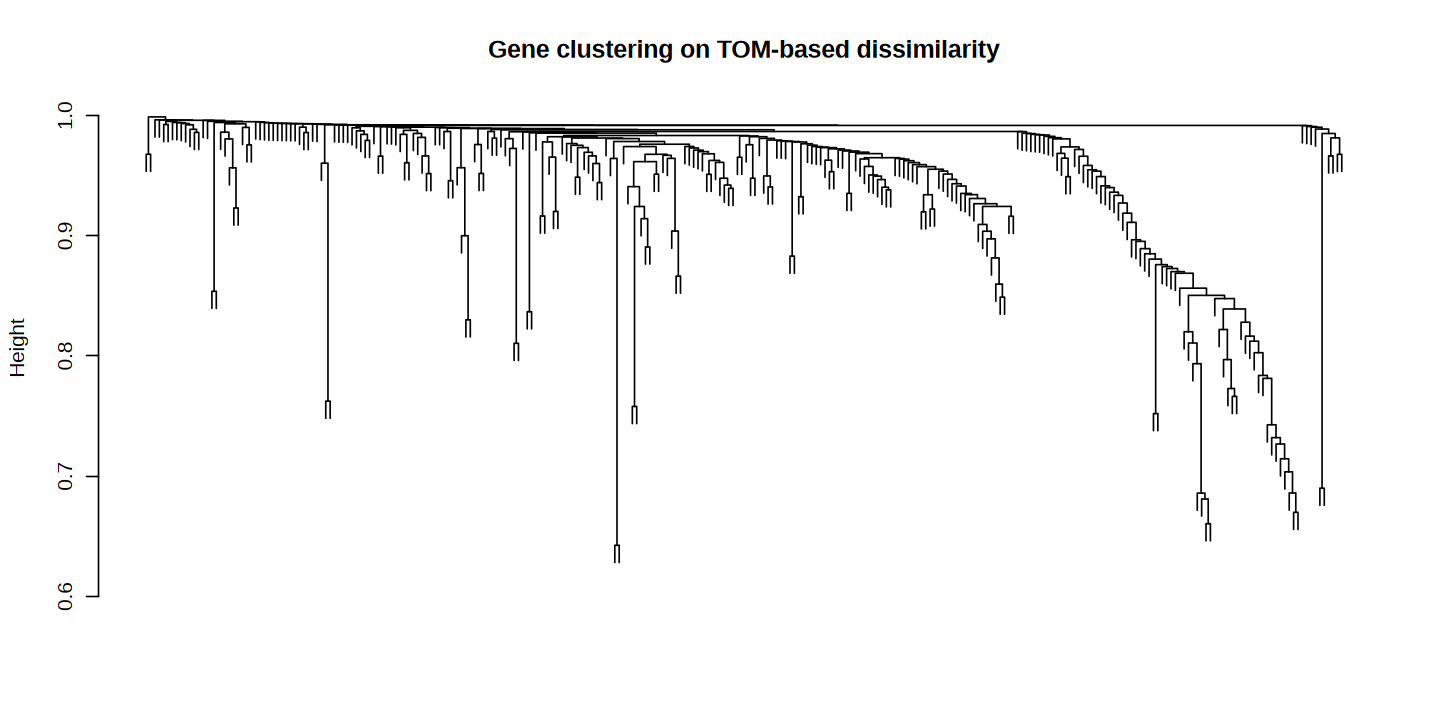

In [607]:
#Call the hierarchical clustering function
geneTree <- hclust(as.dist(dissTOM), method="average")

#Plot the resulting clustering tree (dendrogram)
options(repr.plot.width=12, repr.plot.height=6)
plot(geneTree, xlab="", sub="", main="Gene clustering on TOM-based dissimilarity",
     labels=FALSE, hang=0.04)

> In the clustering tree (dendrogram), each leaf corresponds to a gene. Branches of the dendrogram group together densely interconnected, highly co-expressed genes. Module identification amounts to the identification of individual branches (”cutting the branches off the dendrogram”). There are several methods for branch cutting; the standard method of WGCNA package is Dynamic Tree Cut from the package dynamicTreeCut.  

In [727]:
#Larger modules can be easier to interpret, so we set the minimum module size relatively high
minModuleSize <- max(c(15, round(ncol(data_df)/200, digits=0)))
print(str_c("minClusterSize = ", minModuleSize))

#Module identification using dynamic tree cut
dynamicMods <- cutreeDynamic(dendro=geneTree, distM=dissTOM,
                             deepSplit=4, pamStage=TRUE, pamRespectsDendro=FALSE,
                             minClusterSize=minModuleSize)
table(dynamicMods)

[1] "minClusterSize = 15"
 ..cutHeight not given, setting it to 0.996  ===>  99% of the (truncated) height range in dendro.
 ..done.


dynamicMods
  0   1   2   3 
  3 102  96  73 

> The above list shows each module size. Label 0 is reserved for unassigned genes.  

dynamicColors
     blue     brown      grey turquoise 
       96        73         3       102 

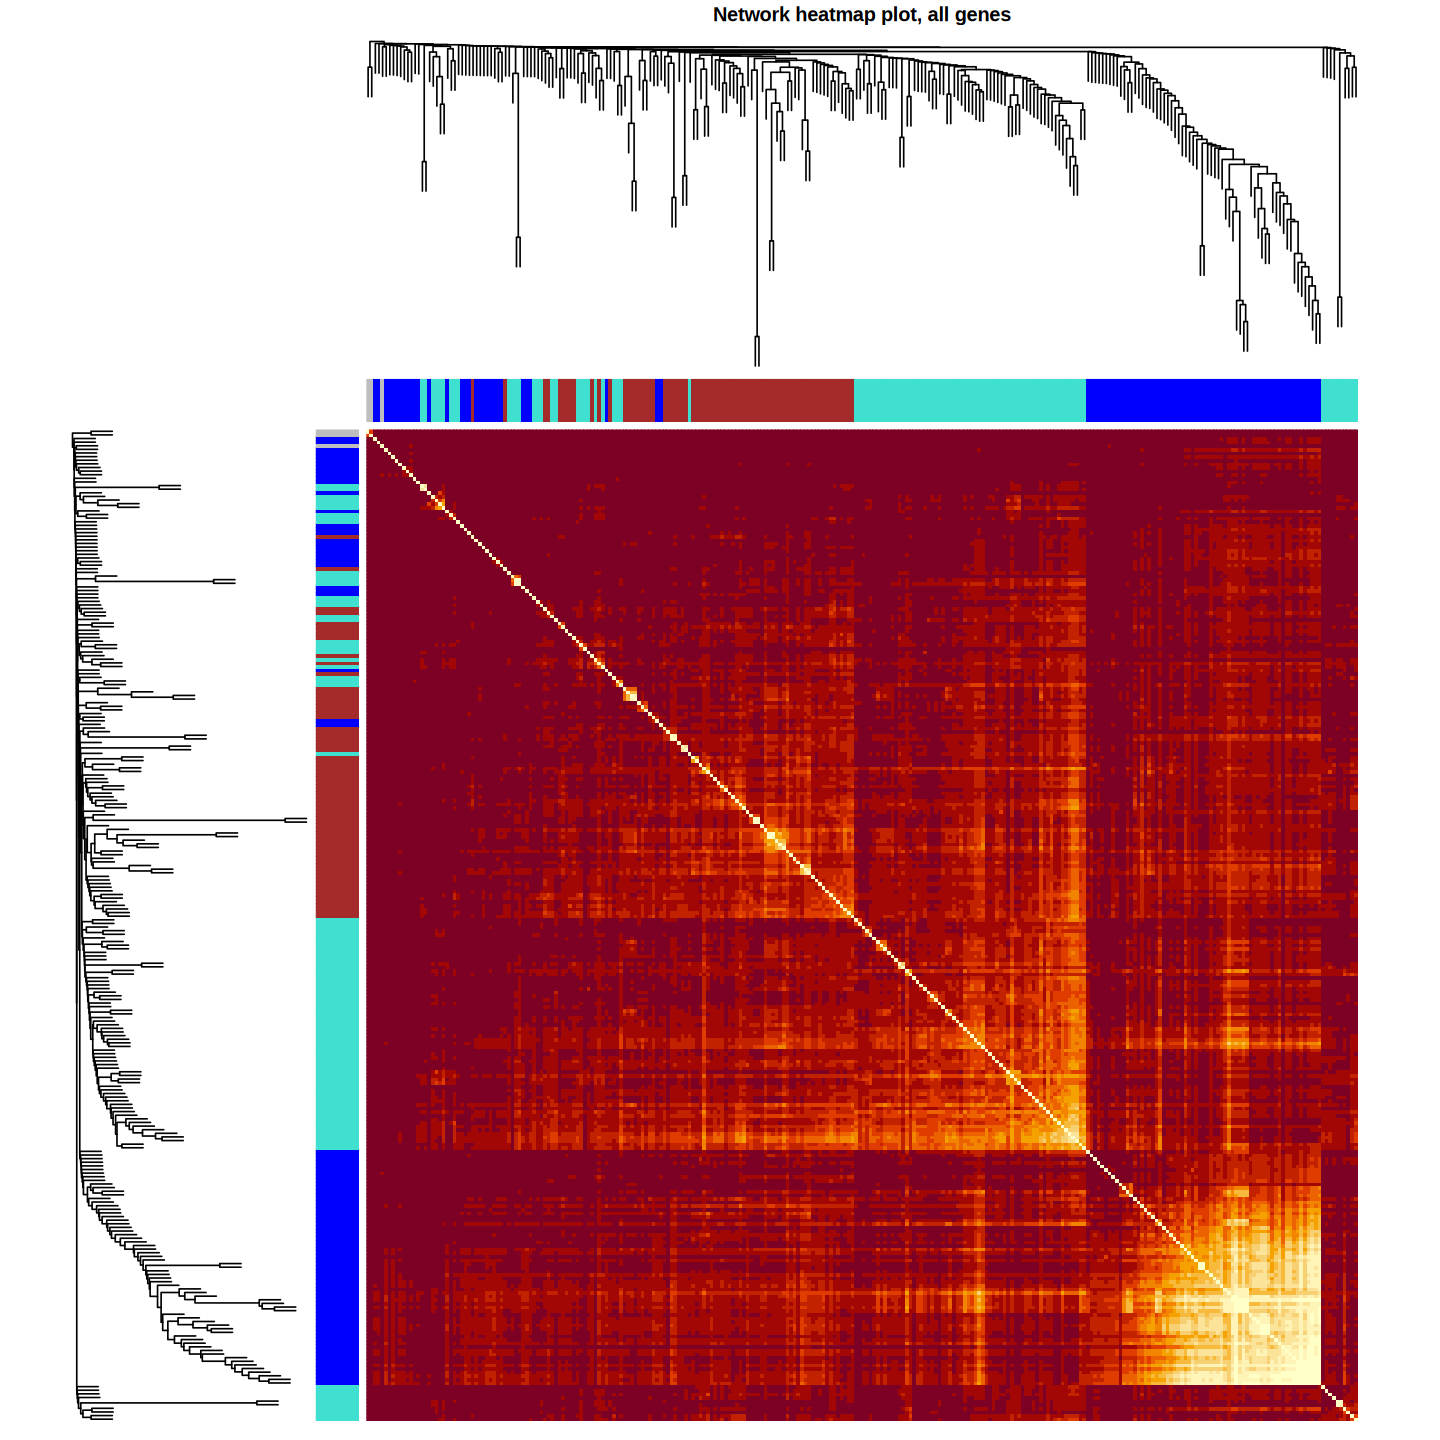

In [728]:
#Convert numeric lables into colors
dynamicColors <- labels2colors(dynamicMods)
table(dynamicColors)

#Plot with TOM dissimilarity matrix
options(repr.plot.width=12, repr.plot.height=12)
TOMplot(dissTOM^softPower,#For better visualization
        geneTree, as.character(mergedColors), main="Network heatmap plot, all genes")

### Merge similar modules based on eigengenes

> Dynamic Tree Cut may identify modules whose expression profiles are very similar. It would be prudent to merge such modules since their genes are highly co-expressed. To quantify co-expression similarity of entire modules, their eigengenes are calculated and clustered based on their correlation.  

[1] "nrow: 1368"


,MEblue,MEbrown,MEgrey,MEturquoise
,<dbl>,<dbl>,<dbl>,<dbl>
01001621,-0.019937975,-0.008346018,0.008234325,-0.002118183
01001661,-0.022733969,-0.024097945,0.013788792,-0.024648951
01002192,-0.001521782,0.016192352,0.007409684,0.046732801
01002885,0.013223608,-0.011343434,-0.004316417,-0.016897681
01003555,0.009400316,0.004134793,0.020418083,0.009675158
01003757,0.019631276,0.017580450,-0.017937074,0.001774422


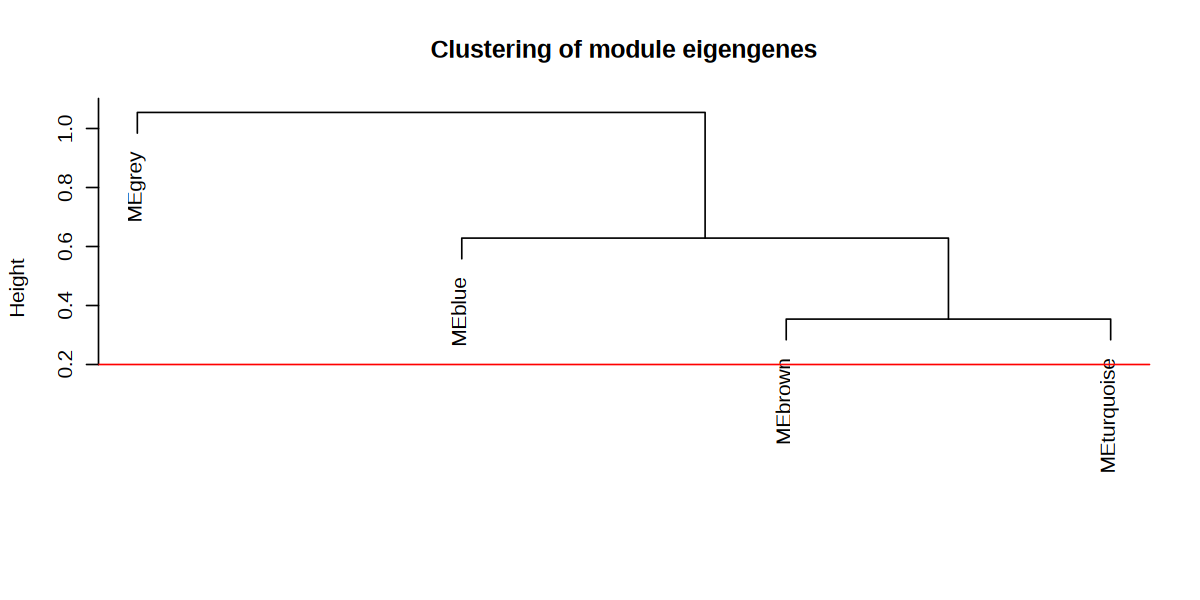

In [729]:
#Calculate eigengenes
MEList <- moduleEigengenes(data_df, colors=dynamicColors, impute=TRUE, nPC=2)
MEs <- MEList$eigengenes
print(str_c("nrow: ", nrow(MEs)))
head(MEs)

#Calculate dissimilarity of module eigengenes
MEDiss <- 1 - cor(MEs, use="pairwise.complete.obs")

#Cluster module eigengenes
METree <- hclust(as.dist(MEDiss), method="average")

#Plot the result
options(repr.plot.width=10, repr.plot.height=5)
plot(METree, main="Clustering of module eigengenes",
     xlab="", sub="")
MEDissThres <- 0.2
abline(h=MEDissThres, col="red")

mergedColors
     blue     brown      grey turquoise 
       96        73         3       102 

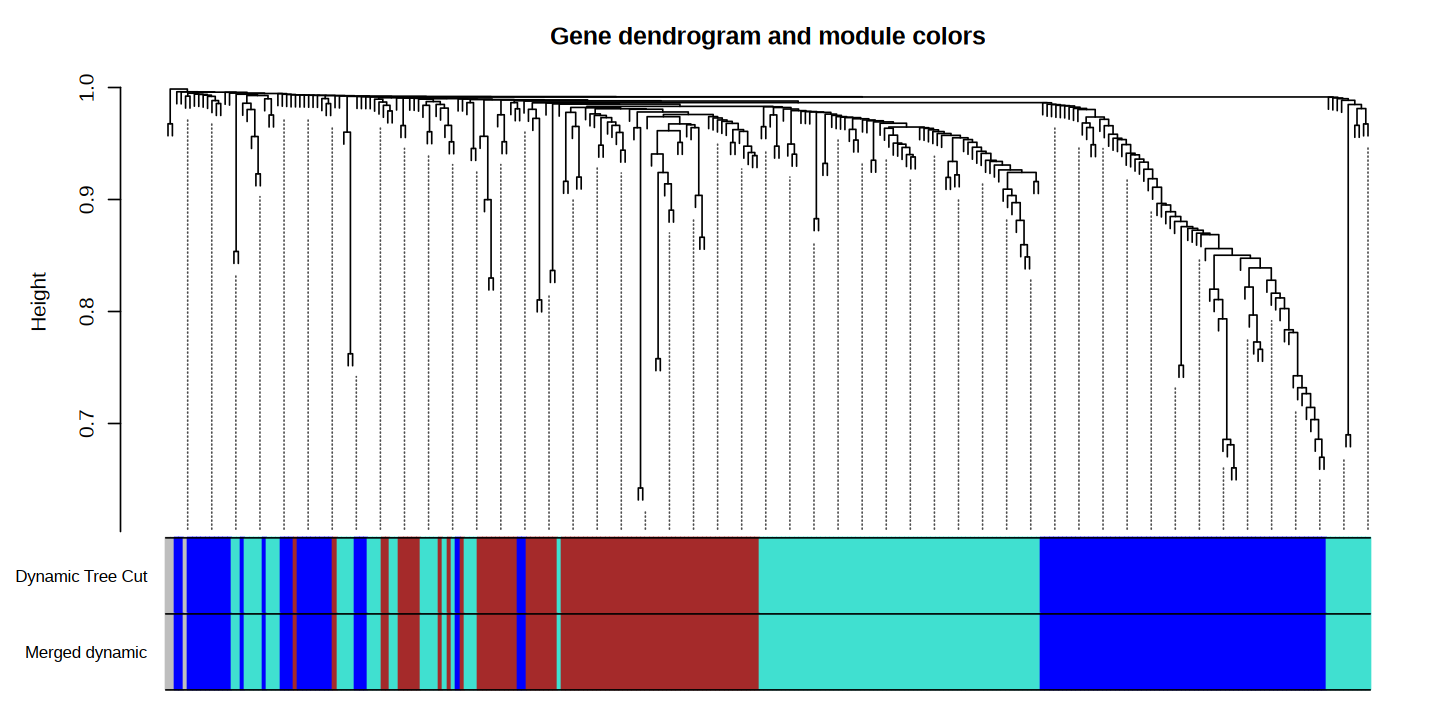

In [730]:
#Call an automatic merging function
merge <- mergeCloseModules(data_df, dynamicColors, cutHeight=MEDissThres, verbose=0)

#Eigengenes of the new merged modules
mergedMEs <- merge$newMEs

#The merged module colors
mergedColors <- merge$colors
table(mergedColors)

#Plot the dendrogram and module colors
options(repr.plot.width=12, repr.plot.height=6)
plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors),
                    c("Dynamic Tree Cut", "Merged dynamic"),
                    dendroLabels=FALSE, hang=0.03,
                    addGuide=TRUE, guideHang=0.05,
                    main="Gene dendrogram and module colors")

In [731]:
#Rename
moduleColors <- mergedColors
MEs <- mergedMEs

#Prepare the module assignment table
module_tbl <- tibble(AnalyteID=colnames(data_df),
                     ModuleID=str_to_title(moduleColors)) %>%
    dplyr::left_join(analyte_tbl, ., by="AnalyteID")
print("Module assignment table (temp)")
print(str_c("- nrow: ", nrow(module_tbl)))
head(module_tbl)

#Clean the module eigengene table
eigengene_df <- MEs %>%
    rownames_to_column(var="public_client_id")
names(eigengene_df)[2:ncol(eigengene_df)] <- names(eigengene_df)[2:ncol(eigengene_df)] %>%
    str_replace(., "^ME", "") %>%
    str_to_title(.)
print("Module eigengene table")
print(str_c("- nrow: ", nrow(eigengene_df)))
head(eigengene_df)

[1] "Module assignment table (temp)"
[1] "- nrow: 274"


AnalyteID,Dataset,AnalyteID_original,PanelID,UniProtID,GeneSymbol,ModuleID
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CVD2_O00182(LGALS9),Proteomics,CVD2_O00182,CVD2,O00182,LGALS9,Brown
CVD2_O00220(TNFRSF10A),Proteomics,CVD2_O00220,CVD2,O00220,TNFRSF10A,Brown
CVD2_O00253(AGRP),Proteomics,CVD2_O00253,CVD2,O00253,AGRP,Blue
CVD2_O14763(TNFRSF10B),Proteomics,CVD2_O14763,CVD2,O14763,TNFRSF10B,Brown
CVD2_O14836(TNFRSF13B),Proteomics,CVD2_O14836,CVD2,O14836,TNFRSF13B,Brown
CVD2_O43915(FIGF),Proteomics,CVD2_O43915,CVD2,O43915,FIGF,Turquoise


[1] "Module eigengene table"
[1] "- nrow: 1368"


,public_client_id,Blue,Brown,Turquoise,Grey
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,01001621,-0.019937975,-0.008346018,-0.002118183,0.008234325
2,01001661,-0.022733969,-0.024097945,-0.024648951,0.013788792
3,01002192,-0.001521782,0.016192352,0.046732801,0.007409684
4,01002885,0.013223608,-0.011343434,-0.016897681,-0.004316417
5,01003555,0.009400316,0.004134793,0.009675158,0.020418083
6,01003757,0.019631276,0.017580450,0.001774422,-0.017937074


## Relationship between each phenotype and module

### Clean phenotype data

In [732]:
#Check phenotypes
print("Sample metadata")
print(str_c("- nrow: ", nrow(sample_tbl)))
print("- Contingency of sex")
table(sample_tbl$sex)
print("- Contingency of race")
table(sample_tbl$race)
print(colnames(sample_tbl))

[1] "Sample metadata"
[1] "- nrow: 1368"
[1] "- Contingency of sex"



  F   M 
870 498 

[1] "- Contingency of race"



                           afro-caribbean 
                                        1 
         american indian or alaska native 
                                        1 
                         ashkenazi jewish 
                                       22 
                                    asian 
                                        8 
                black or african-american 
                                       38 
                               east asian 
                                       52 
        hispanic latino or spanish origin 
                                       78 
          middle eastern or north african 
                                       12 
native hawaiian or other pacific islander 
                                        7 
                                    other 
                                       35 
                         sephardic jewish 
                                        2 
                              south asian 
          

 [1] "...1"             "public_client_id" "self_fi"          "self_fi_sum"     
 [5] "num_na_self"      "days_in_program"  "sex"              "age"             
 [9] "race"             "Dise1"            "Dise2"            "Dise3"           
[13] "Dise4"            "Dise5"            "Dise6"            "Dise7"           
[17] "Dise8"            "Dise9"            "Dise10"           "Dise11"          
[21] "Dise12"           "Dise13"           "Dise14"           "Dise15"          
[25] "SAT_1"            "SAT_2"            "SAT_3"            "SAT_4"           
[29] "SAT_5"            "SAT_6"            "ACT_1"            "ACT_2"           
[33] "ACT_3"            "ACT_4"            "ACT_5"            "ACT_6"           
[37] "ACT_7"            "ACT_8"            "ACT_9"            "Med_1"           
[41] "Med_2"            "Med_3"            "Diges1"           "Diges2"          
[45] "CHEM1"            "CHEM2"            "CHEM3"            "CHEM4"           
[49] "CHEM5"            "CHE

In [733]:
#Code sex and race
phenotype_tbl <- sample_tbl %>%
    dplyr::mutate(BinarySex=ifelse(sex=="F", 0, 1),
                  BinaryRace=ifelse(race=="white", 0, 1)) %>%
    dplyr::mutate(BinaryRace=tidyr::replace_na(.$BinaryRace, 1)) %>%#Due to the existence of NA
    dplyr::select(public_client_id, BinarySex, BinaryRace, age, self_fi, lab_fi, merge_fi) %>%
    #Transform tibble for easily applying to the WGCNA functions
    column_to_rownames(var="public_client_id")

#Check phenotypes
print("Sample metadata")
print(str_c("- nrow: ", nrow(phenotype_tbl)))
print("- Contingency of BinarySex")
table(phenotype_tbl$BinarySex)
print("- Contingency of BinaryRace")
table(phenotype_tbl$BinaryRace)

[1] "Sample metadata"
[1] "- nrow: 1368"
[1] "- Contingency of BinarySex"



  0   1 
870 498 

[1] "- Contingency of BinaryRace"



   0    1 
1051  317 

### Module–trait relationship

> For each module and each phenotype, a quantitative measure of module–trait relationship (MTR) is defined as the correlation between the module eigengene and the phenotype profile.  

[1] "Matched IDs?: TRUE"


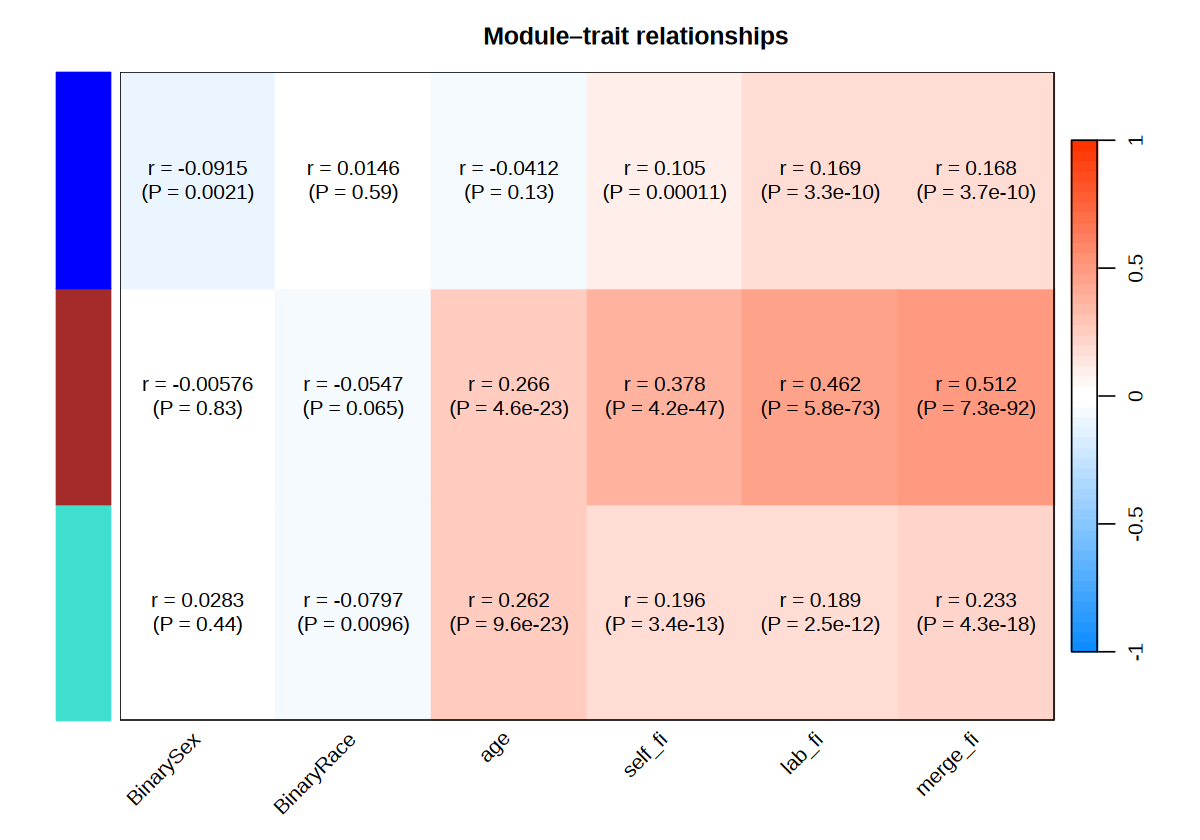

In [734]:
#Calculate the numbers of modules and samples
nSamples <- nrow(phenotype_tbl)
modNames = substring(names(MEs), 3)

##Check ID order before the cor() function
print(str_c("Matched IDs?: ", all(rownames(MEs)==rownames(phenotype_tbl))))

#Calculate module–trait relationship
moduleTraitCor <- as.data.frame(cor(MEs, phenotype_tbl, use="p")) #Pearson correlation
rownames(moduleTraitCor) <- str_to_title(modNames)

#Calculate statisitcal significance of module–trait relationship
MTRpval <- as.data.frame(corPvalueStudent(as.matrix(moduleTraitCor), nSamples)) # Pvalue
rownames(MTRpval) <- str_to_title(modNames)

#Eliminate the dummy module (Grey)
moduleTraitCor <- moduleTraitCor[rownames(moduleTraitCor)!="Grey",]
MTRpval <- MTRpval[rownames(MTRpval)!="Grey",]

#P-value adjustment across modules (per trait) using Benjamini–Hochberg method
MTRpval_adj <- as.data.frame(apply(MTRpval, 2, function(x){p.adjust(x, length(x), method="BH")}))

#Prepare text labels as matrix
textMatrix <- paste("r = ",signif(as.matrix(moduleTraitCor), 3),"\n(P = ",
                    signif(as.matrix(MTRpval_adj), 2),")", sep="")
dim(textMatrix) <- dim(moduleTraitCor)
#Revert module names back to apply color conversion
temp_c <- rownames(moduleTraitCor) %>%
    str_to_lower(.) %>%
    str_c("ME",.)

#Visualize
options(repr.plot.width=10, repr.plot.height=7)
par(mar=c(5, 5, 3, 2))
labeledHeatmap(Matrix=moduleTraitCor,
               xLabels=colnames(moduleTraitCor),
               yLabels=temp_c,
               #ySymbols=rownames(moduleTraitCor),
               colorLabels=FALSE,
               colors=blueWhiteRed(50),
               textMatrix=textMatrix,
               setStdMargins=FALSE,
               cex.text=1,
               zlim=c(-1,1),
               main=paste("Module–trait relationships"))

> –> Because Grey is not a module but a remnant set, it should be removed during tests.  

## *Exercise - WGCNA Race*
Are any modules related to race? We hotcoded race for this example code. But, it is not ideal considering the huge differences in the non-white category. Try the analysis again with better racial categories. 

### Regression analysis

The analysis above is looking at the correlation between the module eigenvector and our outcomes. What if we want to control for covariates? Lets look at a regression analysis and compare. 

In [735]:
#Processing data
temp_df <- phenotype_tbl %>%
    #Standardize continuous variables
    dplyr::mutate(age=c(scale(age, center=TRUE, scale=TRUE)),
                  self_fi=c(scale(self_fi, center=TRUE, scale=TRUE)),
                  lab_fi=c(scale(lab_fi, center=TRUE, scale=TRUE)),
                  merge_fi=c(scale(merge_fi, center=TRUE, scale=TRUE))) %>%
    #Encode categorical variables -> Already done
    #Clean
    rownames_to_column(var="public_client_id")
temp_df <- eigengene_df %>%
    dplyr::select(-Grey) %>%#Remove the dummy module
    dplyr::left_join(., temp_df, by="public_client_id")

head(temp_df)

,public_client_id,Blue,Brown,Turquoise,BinarySex,BinaryRace,age,self_fi,lab_fi,merge_fi
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,01001621,-0.019937975,-0.008346018,-0.002118183,0,0,0.53904815,-0.78008191,-0.8641716,-1.00544102
2,01001661,-0.022733969,-0.024097945,-0.024648951,0,1,-1.40258969,-0.05268170,-0.8641716,-0.58964696
3,01002192,-0.001521782,0.016192352,0.046732801,1,0,-1.72619600,-0.59870420,0.4712805,-0.06150989
4,01002885,0.013223608,-0.011343434,-0.016897681,0,0,-0.43177077,0.01344559,-1.1980346,-0.77355375
5,01003555,0.009400316,0.004134793,0.009675158,1,0,-0.02726289,-0.04907476,1.1390065,0.71709444
6,01003757,0.019631276,0.017580450,0.001774422,0,1,-1.88799915,-0.50623713,1.8067325,0.86436961


[1] "Brown ~ merge_fi + age + BinarySex + BinaryRace"

Call:
lm(formula = str_c(module, " ~ ", xvar, " + ", str_flatten(temp_c, 
    collapse = " + ")), data = temp_df)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.129592 -0.014949 -0.000385  0.013920  0.162692 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0003172  0.0008397  -0.378    0.706    
merge_fi     0.0129522  0.0006440  20.111  < 2e-16 ***
age          0.0037808  0.0006622   5.710 1.39e-08 ***
BinarySex    0.0017341  0.0012957   1.338    0.181    
BinaryRace  -0.0013552  0.0015220  -0.890    0.373    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02293 on 1363 degrees of freedom
Multiple R-squared:  0.2834,	Adjusted R-squared:  0.2813 
F-statistic: 134.7 on 4 and 1363 DF,  p-value: < 2.2e-16



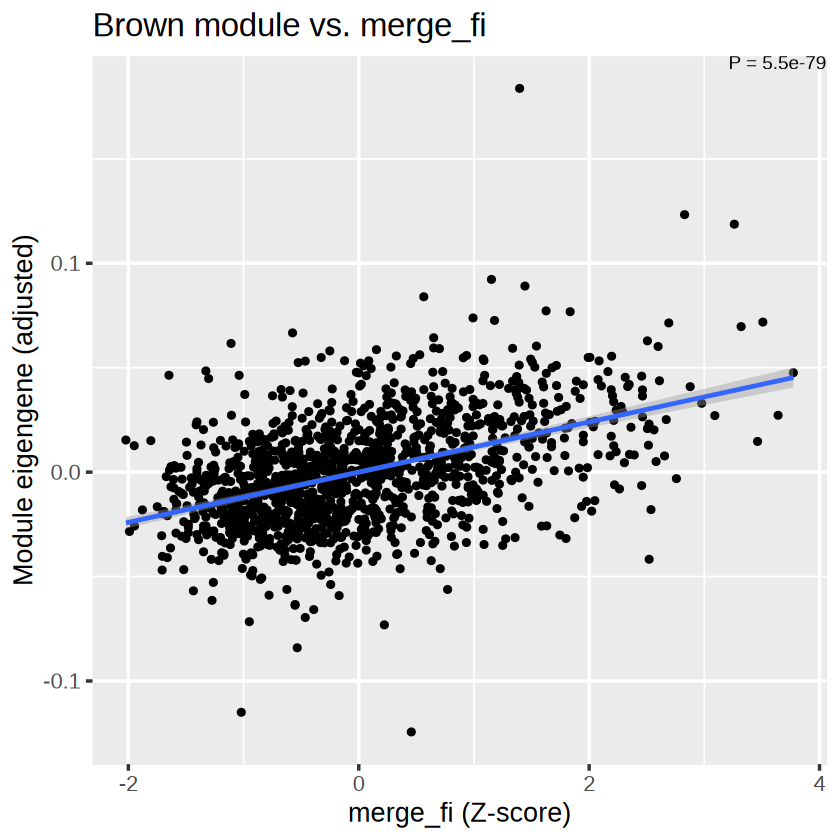

In [736]:
#Regression analysis per module and per age/FI
temp_c <- c("age", "BinarySex", "BinaryRace")#Covariates
module = 'Brown'
xvar <- 'merge_fi'

#OLS regression
model <- lm(formula=str_c(module," ~ ",xvar," + ",str_flatten(temp_c, collapse=' + ')), data=temp_df)
print(str_c(module," ~ ",xvar," + ",str_flatten(temp_c, collapse=' + ')))
print(summary(model))
#Visualize the result
##Calculate the covariate-adjusted module eigengene
model_covar <- lm(formula=str_c(module," ~ ",str_flatten(temp_c, collapse=' + ')), data=temp_df)
plot_df <- temp_df %>%
    dplyr::mutate(AdjME=mean(temp_df[[module]])+model_covar$residuals)
##Prepare model result texts
pval_text <- str_c("P = ",scales::scientific(summary(model)$coefficients[,4][xvar], digits=2))
##Plot correlation
p <- ggplot(data=plot_df) +
    geom_point(aes(x=!!as.name(xvar), y=AdjME)) +
    geom_smooth(aes(x=!!as.name(xvar), y=AdjME), method="lm", formula="y~x", se=TRUE) +
    annotate("text", x=Inf, y=Inf, hjust=1, vjust=1, label=pval_text) +
    labs(x=str_c(xvar," (Z-score)"),
         y="Module eigengene (adjusted)",
         title=str_c(module," module vs. ",xvar)) +
    theme_gray(base_size=16, base_family="Helvetica")
options(repr.plot.width=7, repr.plot.height=7)
plot(p)

## Intramodule connectivity

> Intramodular connectivity can be used to find "hub" analytes in each of the modules. This can be useful to understand potential drivers of each module. 

In [737]:
#Calculate the numbers of genes and samples
#nGenes <- ncol(data_df)
nSamples <- nrow(data_df)

#Names (colors) of the modules
modNames = substring(names(MEs), 3)

##Check ID order before the cor() function
print(str_c("Matched IDs?: ", all(rownames(MEs)==rownames(data_df))))

#Calculate module membership
geneModuleMembership <- as.data.frame(cor(data_df, MEs, use="p"))
#names(geneModuleMembership) <- paste("MM", modNames, sep="")
names(geneModuleMembership) <- str_to_title(modNames)
print("Module membership table")
print(str_c("- nrow: ", nrow(geneModuleMembership)))
head(geneModuleMembership)

#Calculate statisitcal significance of module membership
MMpval <- as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples))
#names(MMpval) <- paste("p.MM", modNames, sep="")
names(MMpval) <- str_to_title(modNames)
print("Module membership p-value table")
print(str_c("- nrow: ", nrow(MMpval)))
head(MMpval)

 softConnectivity: FYI: connecitivty of genes with less than 456 valid samples will be returned as NA.
 ..calculating connectivities.. 
[1] "blue module: 96"
# A tibble: 6 × 4
  ModuleID AnalyteID          IntramodularConnectivity TOMsimilaritySum
  <chr>    <chr>                                 <dbl>            <dbl>
1 Blue     CVD2_O00253(AGRP)                     0.253             1.76
2 Blue     CVD2_O94907(DKK1)                     7.40              8.70
3 Blue     CVD2_P01127(PDGFB)                    7.46              8.86
4 Blue     CVD2_P01241(GH1)                      0.115             1.36
5 Blue     CVD2_P04179(SOD2)                     4.13              6.81
6 Blue     CVD2_P09237(MMP7)                     0.495             2.21
 softConnectivity: FYI: connecitivty of genes with less than 456 valid samples will be returned as NA.
 ..calculating connectivities.. 
[1] "brown module: 73"
# A tibble: 6 × 4
  ModuleID AnalyteID              IntramodularConnectivity TOMsimilarit

ModuleID,AnalyteID,IntramodularConnectivity,TOMsimilaritySum
<chr>,<chr>,<dbl>,<dbl>
Blue,CVD2_O00253(AGRP),0.2528584,1.763670
Blue,CVD2_O94907(DKK1),7.3957050,8.702496
Blue,CVD2_P01127(PDGFB),7.4563654,8.857585
Blue,CVD2_P01241(GH1),0.1152029,1.359076
Blue,CVD2_P04179(SOD2),4.1304963,6.814893
Blue,CVD2_P09237(MMP7),0.4947427,2.211892


[1] "Module assignment table (updated)"
[1] "- nrow: 274"


AnalyteID,Dataset,AnalyteID_original,PanelID,UniProtID,GeneSymbol,ModuleID,IntramodularConnectivity,TOMsimilaritySum
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
CVD2_O00182(LGALS9),Proteomics,CVD2_O00182,CVD2,O00182,LGALS9,Brown,2.3996972,3.107651
CVD2_O00220(TNFRSF10A),Proteomics,CVD2_O00220,CVD2,O00220,TNFRSF10A,Brown,1.3961587,2.362323
CVD2_O00253(AGRP),Proteomics,CVD2_O00253,CVD2,O00253,AGRP,Blue,0.2528584,1.763670
CVD2_O14763(TNFRSF10B),Proteomics,CVD2_O14763,CVD2,O14763,TNFRSF10B,Brown,2.0836974,2.836807
CVD2_O14836(TNFRSF13B),Proteomics,CVD2_O14836,CVD2,O14836,TNFRSF13B,Brown,0.8538012,1.958069
CVD2_O43915(FIGF),Proteomics,CVD2_O43915,CVD2,O43915,FIGF,Turquoise,0.3078484,1.523636


## Enrichment analysis

In [738]:
brown_module <- module_tbl %>%
    dplyr::filter(ModuleID %in% "Brown")
blue_module <- module_tbl %>%
    dplyr::filter(ModuleID %in% "Blue")
turq_module <- module_tbl %>%
    dplyr::filter(ModuleID %in% "Turquoise")

In [739]:
orBP_Brown <- enrichGO(gene          = brown_module$GeneSymbol,
                universe      = module_tbl$GeneSymbol,
                OrgDb         = org.Hs.eg.db,
                ont           = "BP",
                keyType       = "SYMBOL",
                pAdjustMethod = "BH",
                pvalueCutoff  = 1,
                qvalueCutoff  = 1,
        readable      = TRUE)


,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
GO:0002688,GO:0002688,regulation of leukocyte chemotaxis,12/66,18/257,0.0001733769,0.1601611,0.1480618,LGALS9/IL6/CCL3/XCL1/PGF/CCL2/CXCL10/CSF1/CCL4/CCL7/SLAMF1/CCL19
GO:0002690,GO:0002690,positive regulation of leukocyte chemotaxis,11/66,17/257,0.0005118592,0.1601611,0.1480618,LGALS9/IL6/CCL3/XCL1/PGF/CXCL10/CSF1/CCL4/CCL7/SLAMF1/CCL19
GO:0030098,GO:0030098,lymphocyte differentiation,16/66,30/257,0.0005177621,0.1601611,0.1480618,LGALS9/CD4/IL6/CTSL/IL4R/LEP/MERTK/IL18/IL1RL2/IL10/IL12B/TNFRSF9/IL15RA/SLAMF1/IL18R1/CCL19
GO:0030217,GO:0030217,T cell differentiation,12/66,21/257,0.0013725061,0.2591654,0.2395869,LGALS9/CD4/IL6/CTSL/IL4R/LEP/IL18/IL1RL2/IL12B/TNFRSF9/IL18R1/CCL19
GO:1903131,GO:1903131,mononuclear cell differentiation,17/66,35/257,0.0014143900,0.2591654,0.2395869,LGALS9/CD4/IL6/CTSL/IL4R/LEP/MERTK/IL18/IL1RL2/CSF1/IL10/IL12B/TNFRSF9/IL15RA/SLAMF1/IL18R1/CCL19
GO:0043367,GO:0043367,"CD4-positive, alpha-beta T cell differentiation",8/66,12/257,0.0026578092,0.2591654,0.2395869,LGALS9/IL6/CTSL/IL4R/IL18/IL12B/IL18R1/CCL19


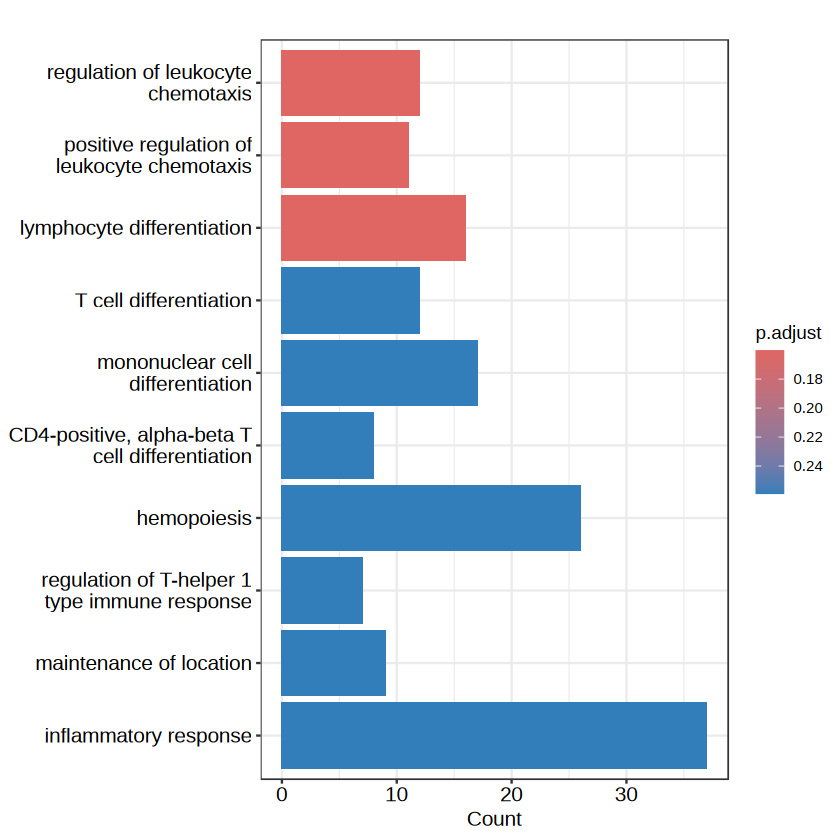

In [740]:
barplot(orBP_Brown, showCategory=10) 
head(orBP_Brown[,1:8])

### 7-1 Hub gene enrichment

In [741]:
topQ <- 0.10 #Focus on the top hubs
hubs_brown <- module_tbl %>%
    dplyr::filter(ModuleID=="Brown") %>%
    dplyr::filter(IntramodularConnectivity>=quantile(IntramodularConnectivity, 1-topQ))

90% 
4.820918

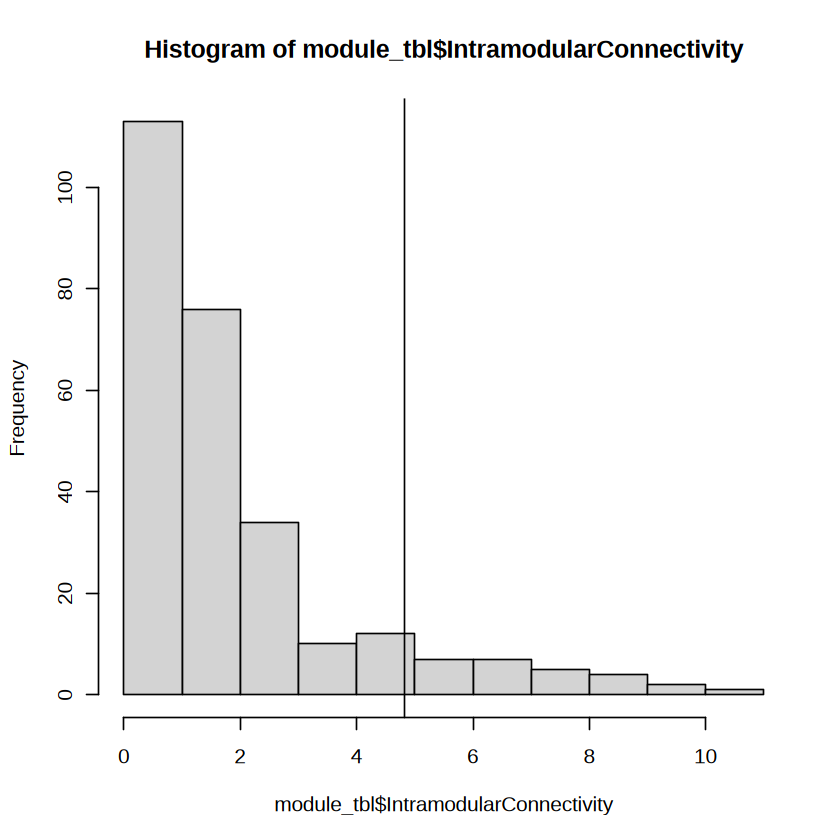

In [745]:
quantile(module_tbl$IntramodularConnectivity, 1-topQ, na.rm=TRUE)
hist(module_tbl$IntramodularConnectivity) 
abline(v=quantile(module_tbl$IntramodularConnectivity, 1-topQ, na.rm=TRUE))

In [743]:
orBP_Brown <- enrichGO(gene          = hubs_brown$GeneSymbol,
                universe      = module_tbl$GeneSymbol,
                OrgDb         = org.Hs.eg.db,
                ont           = "BP",
                keyType       = "SYMBOL",
                pAdjustMethod = "BH",
                pvalueCutoff  = 1,
                qvalueCutoff  = 1,
        readable      = TRUE)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
GO:0070555,GO:0070555,response to interleukin-1,5/6,31/257,0.0001037153,0.03485331,0.02765455,LGALS9/IL6/CCL3/IL1RN/TNFRSF11A
GO:0032940,GO:0032940,secretion by cell,5/6,33/257,0.0001438239,0.03485331,0.02765455,LGALS9/IL6/CCL3/IL1RN/TNFRSF11A
GO:0140352,GO:0140352,export from cell,5/6,33/257,0.0001438239,0.03485331,0.02765455,LGALS9/IL6/CCL3/IL1RN/TNFRSF11A
GO:0046903,GO:0046903,secretion,5/6,36/257,0.0002259567,0.04106763,0.03258533,LGALS9/IL6/CCL3/IL1RN/TNFRSF11A
GO:0001503,GO:0001503,ossification,4/6,19/257,0.0002971027,0.04319873,0.03427627,IL6/CCL3/TNFRSF11A/HGF
GO:0001649,GO:0001649,osteoblast differentiation,3/6,10/257,0.0008061016,0.08371941,0.06642762,IL6/CCL3/HGF


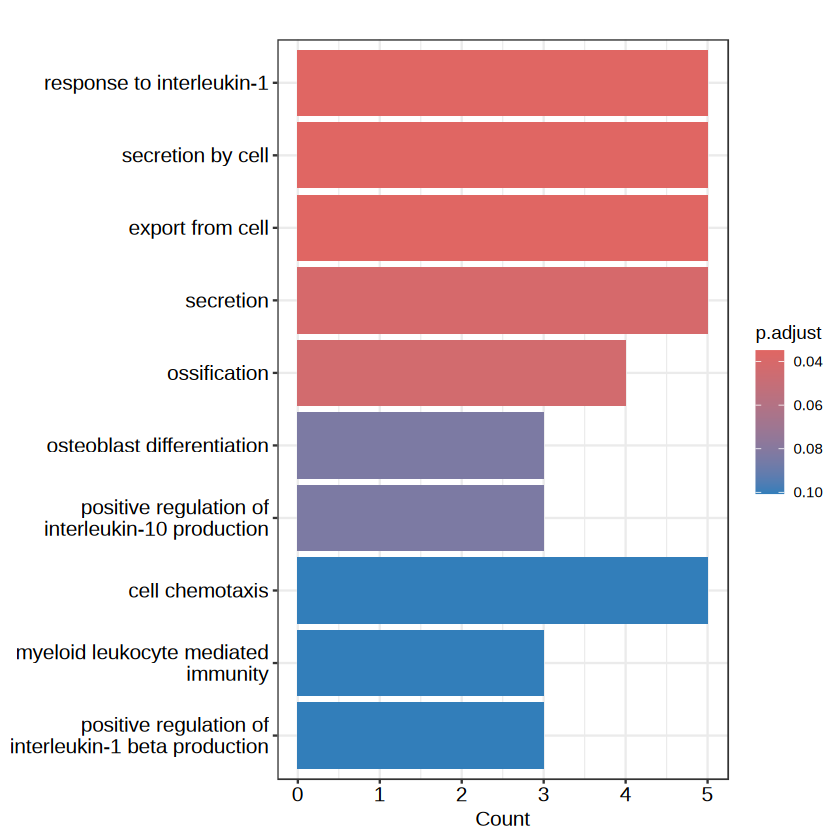

In [744]:
barplot(orBP_Brown, showCategory=10) 
head(orBP_Brown[,1:8])

## *Exercise Metabolites and clinical labs*

We have only touched on proteins for the WGCNA. Perform WGCNA with metabolites and/or clinical labs. Do you find informative modules? How would you do enrichment analysis? 

# Differential Quantification

In [640]:
num_df_med <- scale(data_df, scale = FALSE)
meta_indices_quin <- sample_tbl %>%
    dplyr::mutate(merge_quin = dplyr::ntile(merge_fi, 5)) %>%
    dplyr::mutate(merge_quin = dplyr::case_when(merge_quin == 1 ~'1st', 
                                            merge_quin == 2 ~'2nd',
                                            merge_quin == 3 ~'3rd',
                                            merge_quin == 4 ~'4th',
                                            merge_quin == 5 ~'5th')) %>%
    dplyr::mutate_each_(funs(factor(.)),c("merge_quin", "age", "sex"))

num_df_med_t <- t(num_df_med)

In [649]:
design = model.matrix(~0+group + sex + age)
contrast <- makeContrasts(HighvsLow = group5th-group1st, levels=design)
fit1 <- lmFit(num_df_med_t, design)
fit2 <- contrasts.fit(fit1,contrasts = contrast)
fit3 <- eBayes(fit2)
res <- topTable(fit3, sort.by = "P", n = Inf)

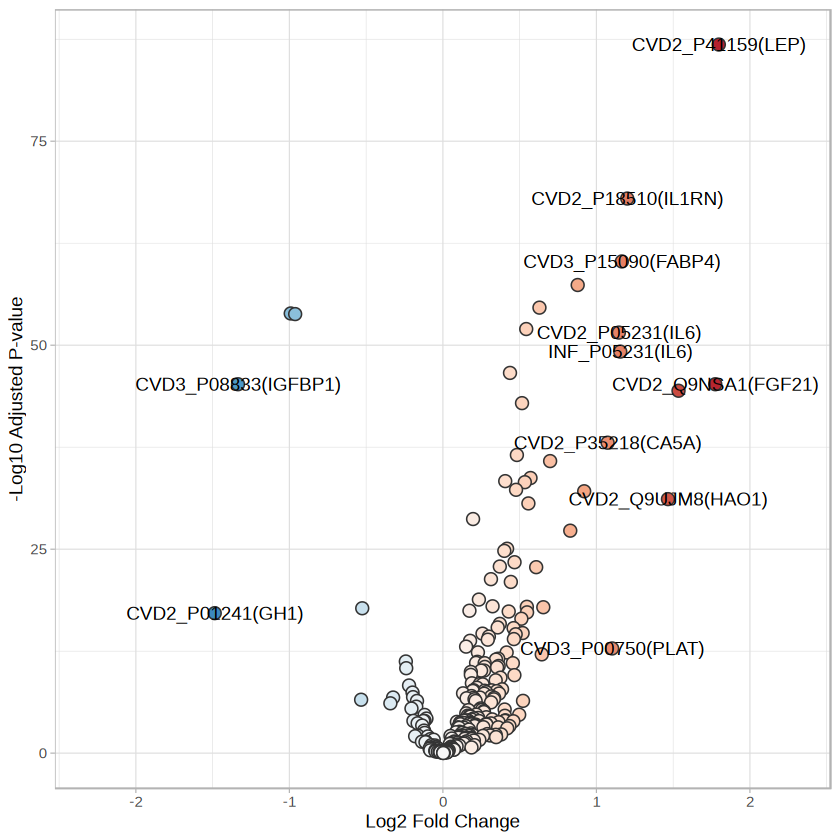

In [650]:
colnames(res) <- c("log2FC", "AveExpr", "t", "pvalue", "padjust", "B")
res$Name <- rownames(res)

x <- res
x$id <- rownames(x)
x$id[(x$padjust > 0.01 | abs(x$log2FC) < 1)] <- NA

fc <- max(abs(x$log2FC), na.rm=TRUE) +.5
clrs = "RdBu"
clrs <- vc_palette(clrs, ramp=FALSE)
#color_ramp <- c(rev(RColorBrewer::brewer.pal(7,"Reds")), "White", RColorBrewer::brewer.pal(7,"Reds"))

p1 <- ggplot2::ggplot(data=x,
              ggplot2::aes(x=log2FC, y= -log10(padjust), label = id)) +
         ggplot2::geom_point(ggplot2::aes(fill = log2FC),
             color="gray20", shape = 21, size=3) +
         ggplot2::xlim( -fc, fc) + ggplot2::theme_light() +
         ggplot2::xlab("Log2 Fold Change") +
         ggplot2::ylab("-Log10 Adjusted P-value") +
         ggplot2::scale_fill_gradientn(colors=clrs, limits=c(-fc, fc),
             guide="none")
options(repr.plot.width=7, repr.plot.height=7)
p1 + geom_text(check_overlap = TRUE)

In [652]:
res$AnalyteID <- rownames(res)
res_modules <- merge(res, module_tbl, by="AnalyteID")
print("Number of DEPs")
print(str_c("- nrow: ", nrow(res_modules %>% filter(padjust <= 0.05))))

print("Number of DEPs overlapping Blue module")
print(str_c("- nrow: ", nrow(res_modules %>% filter(padjust <= 0.05 & ModuleID == 'Blue'))))

print("Number of DEPs overlapping Brown module")
print(str_c("- nrow: ", nrow(res_modules %>% filter(padjust <= 0.05 & ModuleID == 'Brown'))))

print("Number of DEPs overlapping Turquoise module")
print(str_c("- nrow: ", nrow(res_modules %>% filter(padjust <= 0.05 & ModuleID == 'Turquoise'))))


[1] "Number of DEPs"
[1] "- nrow: 213"
[1] "Number of DEPs overlapping Blue module"
[1] "- nrow: 60"
[1] "Number of DEPs overlapping Brown module"
[1] "- nrow: 81"
[1] "Number of DEPs overlapping Turquoise module"
[1] "- nrow: 66"


In [747]:
datatable(res_modules, options = list(searching = TRUE))

HTML widgets cannot be represented in plain text (need html)

In [ ]:
DE_Prots <- res_modules %>%
    dplyr::filter(padjust>=0.05)

orBP_DE <- enrichGO(gene          = DE_Prots$GeneSymbol,
                universe      = module_tbl$GeneSymbol,
                OrgDb         = org.Hs.eg.db,
                ont           = "BP",
                keyType       = "SYMBOL",
                pAdjustMethod = "BH",
                pvalueCutoff  = 1,
                qvalueCutoff  = 1,
        readable      = TRUE)


In [ ]:
barplot(orBP_turq, showCategory=10) 
head(orBP_turq[,1:8])